Step 1/4: Loading and cleaning transfer portal data…
Using transfer CSV: /Users/Gillian/.cache/kagglehub/datasets/dubradave/college-football-portal-and-recruiting-statistics/versions/2/CFB_Portal_Data.csv
Rows: 6,547 | Columns: 11 | Date coverage: 2020-08-01 00:00:00 → 2023-07-06 22:31:00

Step 2/4: Basic statistical summaries…

Missingness overview (top 10 columns):

Step 3/4: Distribution checks & outlier flags…
Potential numeric outliers (Tukey rule):


/var/folders/v3/t_6zr38j6kb0bq90clldf46w0000gr/T/ipykernel_61896/167082546.py:144: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ordered_labels)


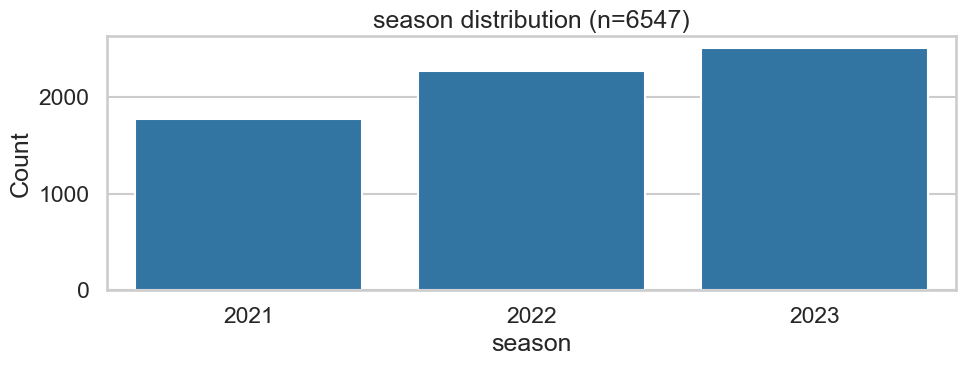

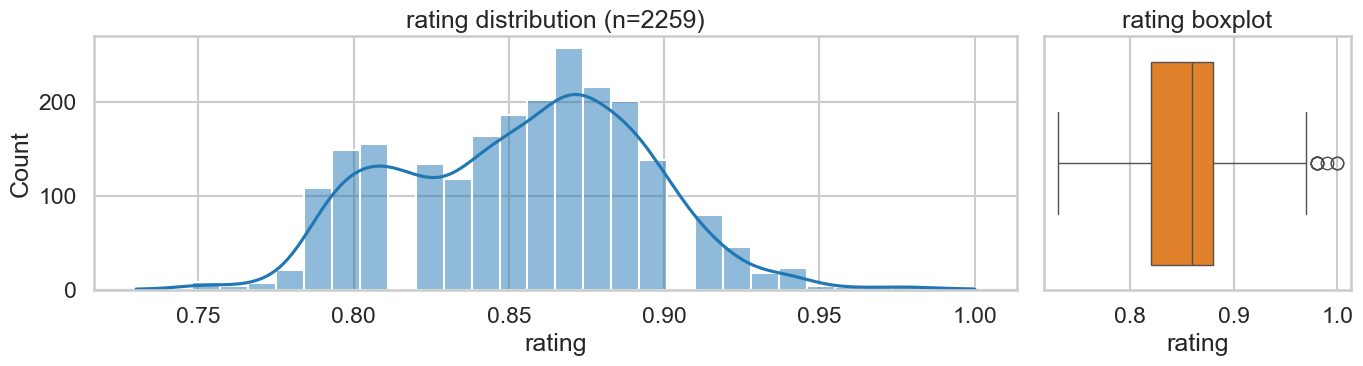

/var/folders/v3/t_6zr38j6kb0bq90clldf46w0000gr/T/ipykernel_61896/167082546.py:158: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ordered_labels)


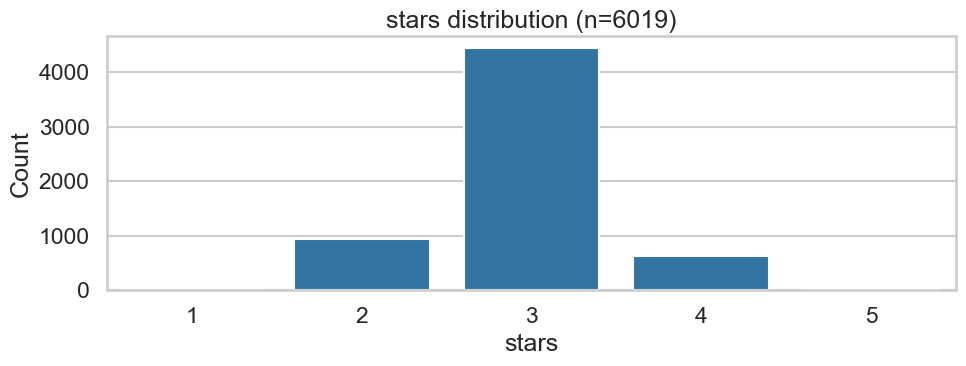

/var/folders/v3/t_6zr38j6kb0bq90clldf46w0000gr/T/ipykernel_61896/167082546.py:175: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.index.astype(str), y=top_counts.values, palette="viridis")


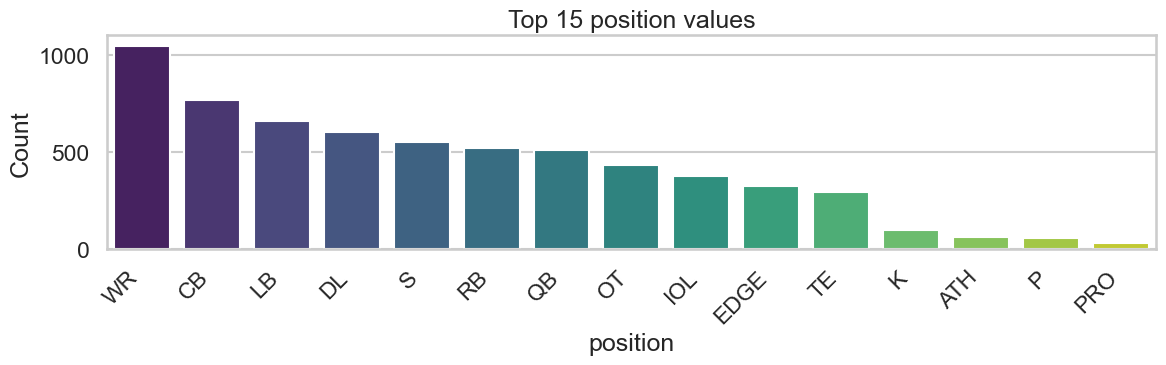

/var/folders/v3/t_6zr38j6kb0bq90clldf46w0000gr/T/ipykernel_61896/167082546.py:175: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.index.astype(str), y=top_counts.values, palette="viridis")


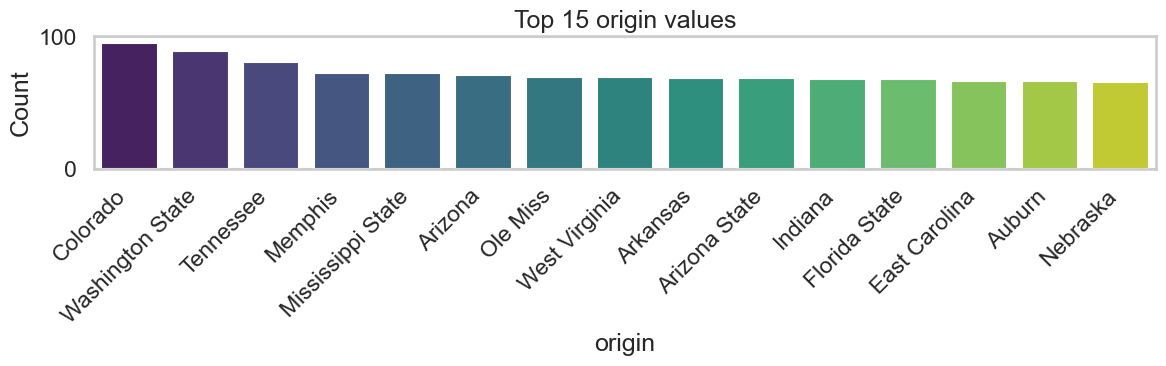

/var/folders/v3/t_6zr38j6kb0bq90clldf46w0000gr/T/ipykernel_61896/167082546.py:175: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.index.astype(str), y=top_counts.values, palette="viridis")


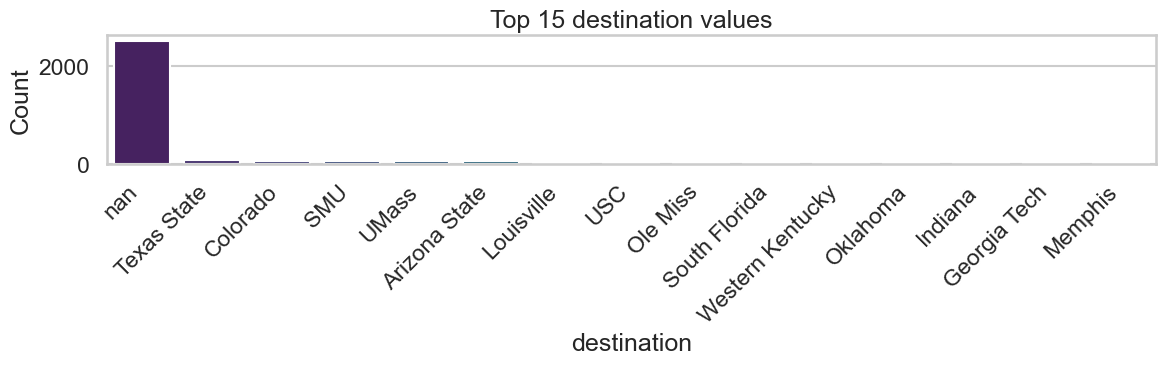

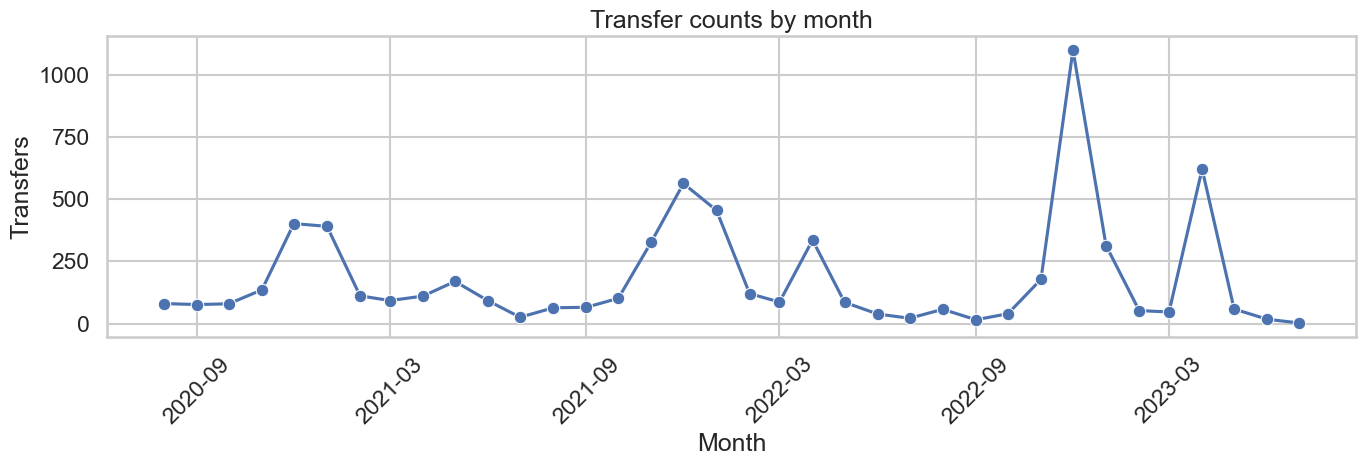


Step 4/4: Correlations & relationships…


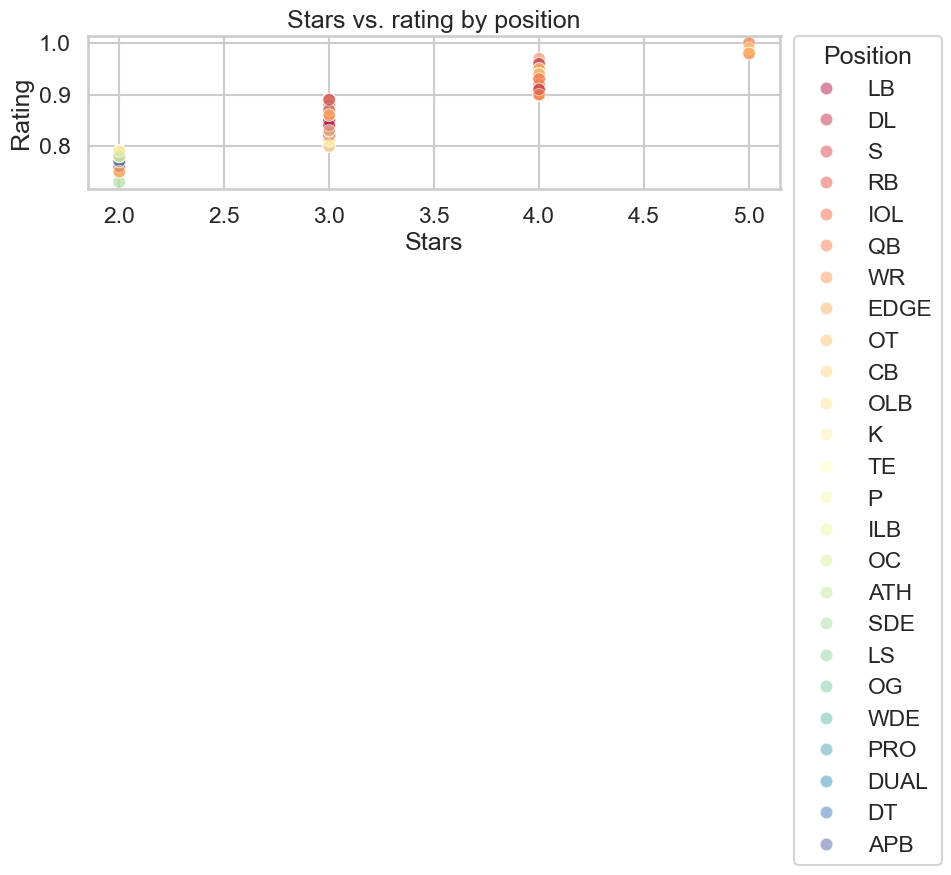

/var/folders/v3/t_6zr38j6kb0bq90clldf46w0000gr/T/ipykernel_61896/167082546.py:243: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


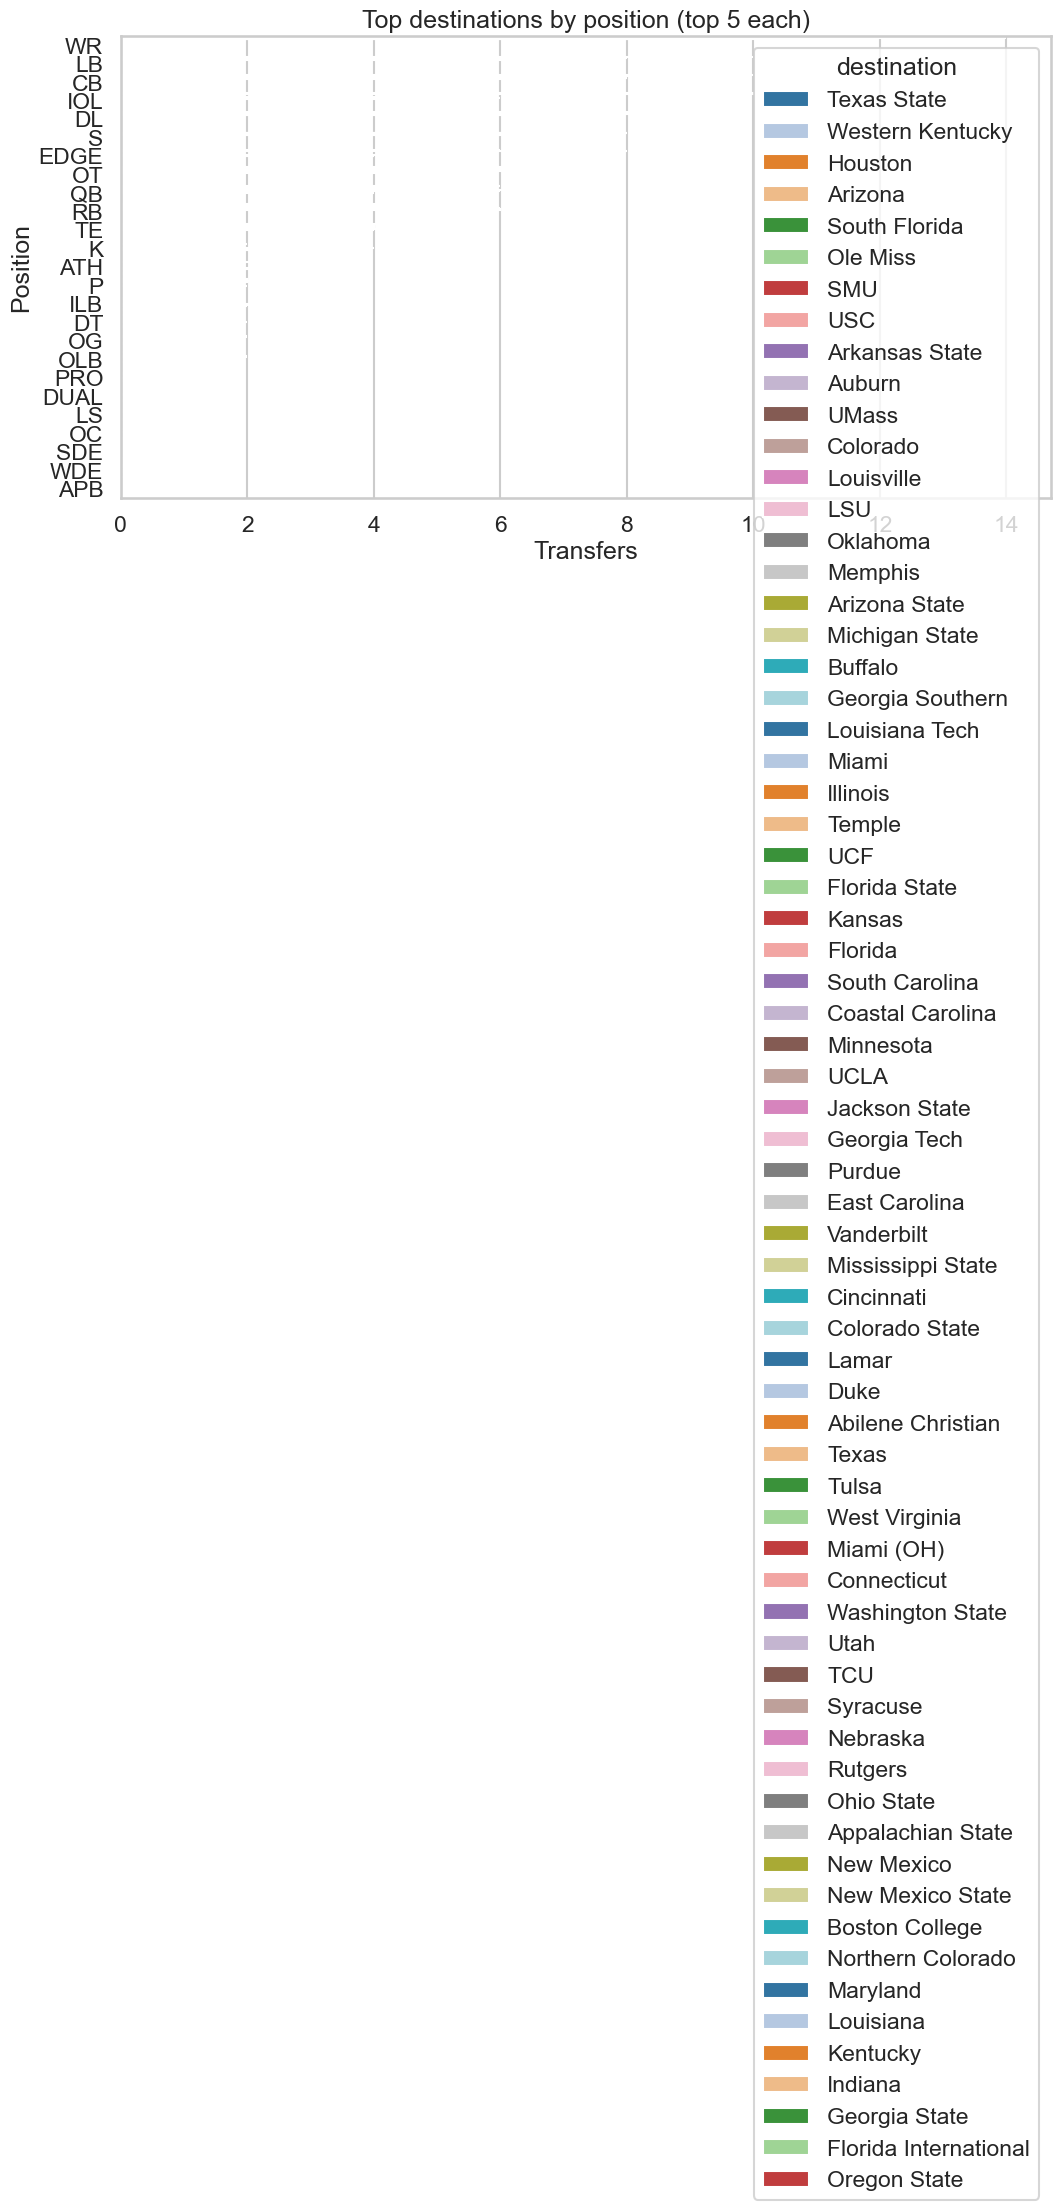

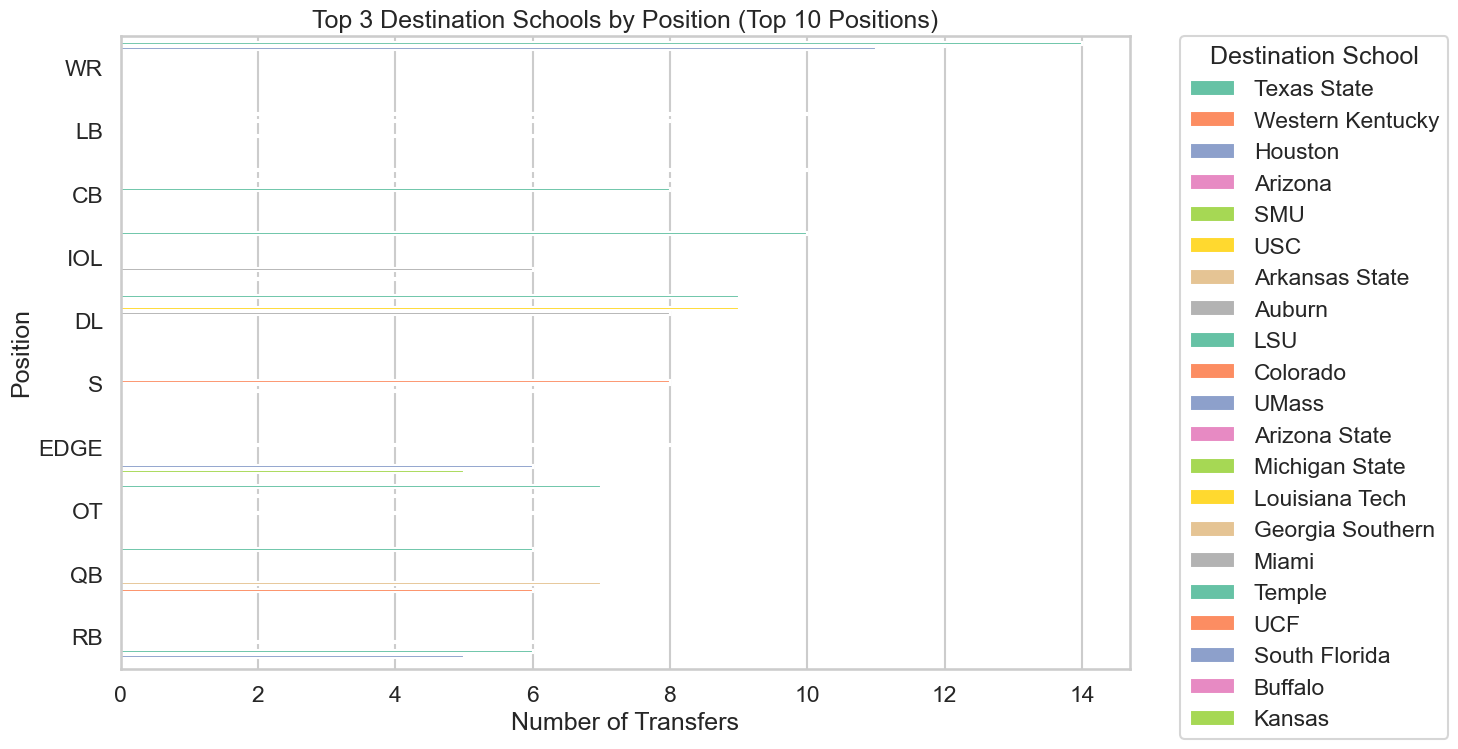


Next actions: Review printed tables for key stats, note any flagged outliers, and capture plots that best illustrate emerging stories or modeling considerations.


In [5]:
import os, glob, re
from collections import OrderedDict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import kagglehub

sns.set_theme(style="whitegrid", context="talk")
pd.set_option("display.max_columns", 200)

print("Step 1/4: Loading and cleaning transfer portal data…")
root = kagglehub.dataset_download("dubradave/college-football-portal-and-recruiting-statistics")
transfer_candidates = [
    path for path in glob.glob(os.path.join(root, "**", "*.csv"), recursive=True)
    if "portal" in os.path.basename(path).lower()
]
if not transfer_candidates:
    raise FileNotFoundError("No transfer CSV found in the Kaggle dataset.")
transfer_path = sorted(transfer_candidates)[0]
print(f"Using transfer CSV: {transfer_path}")

raw_transfer_df = pd.read_csv(transfer_path)

def normalize_columns(columns):
    normalized = []
    seen = set()
    for name in columns:
        clean = re.sub(r"[^a-z0-9]+", "_", str(name).strip().lower()).strip("_")
        if not clean:
            clean = "unnamed"
        deduped = clean
        counter = 2
        while deduped in seen:
            deduped = f"{clean}_{counter}"
            counter += 1
        seen.add(deduped)
        normalized.append(deduped)
    return normalized

transfer_df = raw_transfer_df.copy()
transfer_df.columns = normalize_columns(transfer_df.columns)

if "transfer_date" in transfer_df.columns:
    transfer_df["transfer_date"] = (
        pd.to_datetime(transfer_df["transfer_date"], errors="coerce", utc=True)
          .dt.tz_localize(None)
    )

numeric_like = {"rating", "stars", "eligibility", "season", "year"}
for col in numeric_like.intersection(transfer_df.columns):
    transfer_df[col] = pd.to_numeric(transfer_df[col], errors="coerce")

print(
    f"Rows: {len(transfer_df):,} | Columns: {len(transfer_df.columns)} | "
    f"Date coverage: {transfer_df['transfer_date'].min()} → {transfer_df['transfer_date'].max()}"
    if "transfer_date" in transfer_df.columns else ""
)

print("\nStep 2/4: Basic statistical summaries…")
try:
    summary_table = transfer_df.describe(include="all", datetime_is_numeric=True).T
except TypeError:
    summary_table = transfer_df.describe(include="all").T
    datetime_cols = transfer_df.select_dtypes(include=["datetime64[ns]"])
    if not datetime_cols.empty:
        dt_bounds = datetime_cols.agg(["min", "max"])
        for col in dt_bounds:
            summary_table.loc[col, "min"] = dt_bounds.loc["min", col]
            summary_table.loc[col, "max"] = dt_bounds.loc["max", col]

summary_table["missing_pct"] = transfer_df.isna().mean()
summary_table["distinct"] = transfer_df.nunique(dropna=True)
summary_table = summary_table.sort_index()
summary_table

missing_summary = (
    transfer_df.isna()
    .sum()
    .to_frame(name="missing_count")
    .assign(missing_pct=lambda df_: df_["missing_count"] / len(transfer_df))
    .sort_values("missing_count", ascending=False)
)
print("\nMissingness overview (top 10 columns):")
missing_summary.head(10)

name_exclusions = {"first_name", "last_name"}
cat_cols = [
    col for col in transfer_df.columns
    if (transfer_df[col].dtype == "object" or transfer_df[col].dtype.name == "category")
    and col not in name_exclusions
]
num_cols = [
    col for col in transfer_df.select_dtypes(include=["number", "float64", "int64"]).columns
    if not col.startswith("unnamed")
]

print("\nStep 3/4: Distribution checks & outlier flags…")
outlier_report = OrderedDict()
for col in num_cols:
    series = transfer_df[col].dropna()
    if series.empty:
        continue
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1 if q3 > q1 else np.nan
    if pd.isna(iqr) or iqr == 0:
        continue
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = series[(series < lower) | (series > upper)]
    if not outliers.empty:
        outlier_report[col] = {
            "lower_bound": lower,
            "upper_bound": upper,
            "outlier_count": len(outliers),
            "pct_of_total": len(outliers) / len(series),
            "min_outlier": outliers.min(),
            "max_outlier": outliers.max(),
        }

if outlier_report:
    print("Potential numeric outliers (Tukey rule):")
    pd.DataFrame(outlier_report).T.sort_values("pct_of_total", ascending=False)
else:
    print("No strong numeric outliers detected with Tukey rule.")

for col in num_cols:
    series = transfer_df[col].dropna()
    if series.empty:
        continue

    if col in {"season", "year"}:
        ordered = sorted(series.dropna().astype(float).unique())
        ordered_labels = [str(int(x)) if float(x).is_integer() else f"{x:g}" for x in ordered]
        plotted = pd.Categorical(series.astype(float), categories=ordered, ordered=True)
        plt.figure(figsize=(10, 4))
        ax = sns.countplot(x=plotted, color="#2077b4")
        ax.set_title(f"{col} distribution (n={len(series)})")
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        ax.set_xticklabels(ordered_labels)
        plt.tight_layout()
        plt.show()
        continue

    if col == "stars":
        ordered = sorted(series.unique())
        ordered_labels = [f"{x:g}" for x in ordered]
        plotted = pd.Categorical(series, categories=ordered, ordered=True)
        plt.figure(figsize=(10, 4))
        ax = sns.countplot(x=plotted, color="#2077b4")
        ax.set_title(f"{col} distribution (n={len(series)})")
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        ax.set_xticklabels(ordered_labels)
        plt.tight_layout()
        plt.show()
        continue

    fig, axes = plt.subplots(1, 2, figsize=(14, 4), gridspec_kw={"width_ratios": [3, 1]})
    sns.histplot(series, kde=True, ax=axes[0], color="#2077b4")
    axes[0].set_title(f"{col} distribution (n={len(series)})")
    sns.boxplot(x=series, ax=axes[1], color="#ff7f0e")
    axes[1].set_title(f"{col} boxplot")
    axes[1].set_yticks([])
    plt.tight_layout()
    plt.show()

for col in cat_cols:
    top_counts = transfer_df[col].value_counts(dropna=False).head(15)
    plt.figure(figsize=(12, 4))
    sns.barplot(x=top_counts.index.astype(str), y=top_counts.values, palette="viridis")
    plt.title(f"Top {len(top_counts)} {col} values")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

if "transfer_date" in transfer_df.columns:
    timeline = (
        transfer_df.dropna(subset=["transfer_date"])
        .assign(month=lambda df_: df_["transfer_date"].dt.to_period("M"))
        .groupby("month")
        .size()
        .reset_index(name="transfer_events")
        .assign(month=lambda df_: df_["month"].dt.to_timestamp())
    )
    plt.figure(figsize=(14, 5))
    sns.lineplot(data=timeline, x="month", y="transfer_events", marker="o")
    plt.title("Transfer counts by month")
    plt.xlabel("Month")
    plt.ylabel("Transfers")
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

print("\nStep 4/4: Correlations & relationships…")

if {"stars", "rating"}.issubset(transfer_df.columns):
    plt.figure(figsize=(10, 6))
    hue_col = "position" if "position" in transfer_df.columns else None
    ax = sns.scatterplot(
        data=transfer_df,
        x="stars",
        y="rating",
        hue=hue_col,
        alpha=0.5,
        palette="Spectral" if hue_col else None,
    )
    plt.title("Stars vs. rating by position" if hue_col else "Stars vs. rating")
    plt.xlabel("Stars")
    plt.ylabel("Rating")
    if hue_col:
        ax.legend(title="Position", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
    plt.tight_layout()
    plt.show()

if {"destination", "position"}.issubset(transfer_df.columns):
    top_dest_by_pos = (
        transfer_df.groupby(["position", "destination"])
        .size()
        .reset_index(name="transfers")
        .sort_values("transfers", ascending=False)
        .groupby("position")
        .head(5)
    )
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=top_dest_by_pos,
        y="position",
        x="transfers",
        hue="destination",
        palette="tab20"
    )
    plt.title("Top destinations by position (top 5 each)")
    plt.xlabel("Transfers")
    plt.ylabel("Position")
    plt.tight_layout()
    plt.show()

###if {"destination", "position"}.issubset(transfer_df.columns):
    # Group and aggregate data, but limit to top positions and schools
    top_dest_by_pos = (
        transfer_df.dropna(subset=["position", "destination"])
        .groupby(["position"])
        .size()
        .sort_values(ascending=False)
        .head(10)  # Limit to top 10 positions
        .index
    )
    
    filtered_data = (
        transfer_df[transfer_df["position"].isin(top_dest_by_pos)]
        .groupby(["position", "destination"])
        .size()
        .reset_index(name="transfers")
        .sort_values("transfers", ascending=False)
        .groupby("position")
        .head(3)  # Show only top 3 schools per position
    )
    
    plt.figure(figsize=(15, 8))
    ax = sns.barplot(
        data=filtered_data,
        y="position",
        x="transfers",
        hue="destination",
        palette="Set2",
        saturation=1
    )
    
    plt.title("Top 3 Destination Schools by Position (Top 10 Positions)")
    plt.xlabel("Number of Transfers")
    plt.ylabel("Position")
    
    # Adjust legend
    plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0,
        title="Destination School"
    )
    
    plt.tight_layout()
    plt.show()

print("\nNext actions: Review printed tables for key stats, note any flagged outliers, and capture plots that best illustrate emerging stories or modeling considerations.")


In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display

DATA_COLLECTION_NOTE = (
    "Scraped NCAA transfer portal entries as published on Kaggle "
    "(dubradave/college-football-portal-and-recruiting-statistics)."
)

TEMPORAL_KEYS = {"date", "year", "season"}
GEOGRAPHIC_KEYS = {"state", "country", "region", "conference"}
ORDINAL_KEYS = {"rank", "rating", "level", "stars"}

def classify_variable(name: str, series: pd.Series) -> str:
    lname = name.lower()
    if any(key in lname for key in TEMPORAL_KEYS):
        return "temporal"
    if any(key in lname for key in GEOGRAPHIC_KEYS):
        return "geographic"
    if any(key in lname for key in ORDINAL_KEYS):
        return "ordinal"
    if pd.api.types.is_numeric_dtype(series):
        return "quantitative"
    return "categorical"

records = []
for col in df.columns:
    series = df[col]
    inferred_type = classify_variable(col, series)
    dtype = str(series.dtype)
    non_null = int(series.notna().sum())
    total = len(series)
    missing = total - non_null
    missing_pct = round((missing / total) * 100, 2) if total else 0.0

    if pd.api.types.is_numeric_dtype(series):
        value_min = float(series.min()) if series.notna().any() else np.nan
        value_max = float(series.max()) if series.notna().any() else np.nan
    elif pd.api.types.is_datetime64_any_dtype(series):
        value_min = series.min().strftime("%Y-%m-%d") if series.notna().any() else None
        value_max = series.max().strftime("%Y-%m-%d") if series.notna().any() else None
    else:
        samples = series.dropna().unique()[:3]
        value_min = ", ".join(map(str, samples)) if len(samples) else None
        value_max = None

    records.append(
        {
            "variable": col,
            "python_dtype": dtype,
            "inferred_type": inferred_type,
            "value_min_or_sample": value_min,
            "value_max": value_max,
            "non_null": non_null,
            "missing": missing,
            "missing_pct": missing_pct,
            "collection_note": DATA_COLLECTION_NOTE,
        }
    )

variable_dictionary = pd.DataFrame(records)

print("Dataset shape:", df.shape[0], "rows ×", df.shape[1], "columns")
display(variable_dictionary)


Dataset shape: 6547 rows × 13 columns


,variable,python_dtype,inferred_type,value_min_or_sample,value_max,non_null,missing,missing_pct,collection_note
0,unnamed_0,int64,quantitative,0.0,6546.0,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
1,season,int64,temporal,2021.0,2023.0,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
2,first_name,object,categorical,"Cameron, Stephon, Javar",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
3,last_name,object,categorical,"Wilkins, Wright, Strong",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
4,position,object,categorical,"LB, DL, S",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
5,origin,object,categorical,"Missouri, Arizona State, Arkansas State",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
6,destination,object,categorical,"UT San Antonio, SMU, Western Kentucky",NaN,4034,2513,38.38,Scraped NCAA transfer portal entries as publis...
7,transfer_date,object,temporal,"2021-07-31T14:46:00.000Z, 2021-07-29T15:50:00....",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
8,rating,float64,ordinal,0.73,1.0,2259,4288,65.50,Scraped NCAA transfer portal entries as publis...
9,stars,float64,ordinal,1.0,5.0,6019,528,8.06,Scraped NCAA transfer portal entries as publis...


In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display

DATA_COLLECTION_NOTE = (
    "Scraped NCAA transfer portal entries as published on Kaggle "
    "(dubradave/college-football-portal-and-recruiting-statistics)."
)

TEMPORAL_KEYS = {"date", "year", "season"}
GEOGRAPHIC_KEYS = {"state", "country", "region", "conference"}
ORDINAL_KEYS = {"rank", "rating", "level", "stars"}

def classify_variable(name: str, series: pd.Series) -> str:
    lname = name.lower()
    if any(key in lname for key in TEMPORAL_KEYS):
        return "temporal"
    if any(key in lname for key in GEOGRAPHIC_KEYS):
        return "geographic"
    if any(key in lname for key in ORDINAL_KEYS):
        return "ordinal"
    if pd.api.types.is_numeric_dtype(series):
        return "quantitative"
    return "categorical"

records = []
for col in df.columns:
    series = df[col]
    inferred_type = classify_variable(col, series)
    dtype = str(series.dtype)
    non_null = int(series.notna().sum())
    total = len(series)
    missing = total - non_null
    missing_pct = round((missing / total) * 100, 2) if total else 0.0

    if pd.api.types.is_numeric_dtype(series):
        value_min = float(series.min()) if series.notna().any() else np.nan
        value_max = float(series.max()) if series.notna().any() else np.nan
    elif pd.api.types.is_datetime64_any_dtype(series):
        value_min = series.min().strftime("%Y-%m-%d") if series.notna().any() else None
        value_max = series.max().strftime("%Y-%m-%d") if series.notna().any() else None
    else:
        samples = series.dropna().unique()[:3]
        value_min = ", ".join(map(str, samples)) if len(samples) else None
        value_max = None

    records.append(
        {
            "variable": col,
            "python_dtype": dtype,
            "inferred_type": inferred_type,
            "value_min_or_sample": value_min,
            "value_max": value_max,
            "non_null": non_null,
            "missing": missing,
            "missing_pct": missing_pct,
            "collection_note": DATA_COLLECTION_NOTE,
        }
    )

variable_dictionary = pd.DataFrame(records)

print("Dataset shape:", df.shape[0], "rows ×", df.shape[1], "columns")
display(variable_dictionary)


Dataset shape: 6547 rows × 13 columns


,variable,python_dtype,inferred_type,value_min_or_sample,value_max,non_null,missing,missing_pct,collection_note
0,unnamed_0,int64,quantitative,0.0,6546.0,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
1,season,int64,temporal,2021.0,2023.0,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
2,first_name,object,categorical,"Cameron, Stephon, Javar",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
3,last_name,object,categorical,"Wilkins, Wright, Strong",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
4,position,object,categorical,"LB, DL, S",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
5,origin,object,categorical,"Missouri, Arizona State, Arkansas State",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
6,destination,object,categorical,"UT San Antonio, SMU, Western Kentucky",NaN,4034,2513,38.38,Scraped NCAA transfer portal entries as publis...
7,transfer_date,object,temporal,"2021-07-31T14:46:00.000Z, 2021-07-29T15:50:00....",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
8,rating,float64,ordinal,0.73,1.0,2259,4288,65.50,Scraped NCAA transfer portal entries as publis...
9,stars,float64,ordinal,1.0,5.0,6019,528,8.06,Scraped NCAA transfer portal entries as publis...


In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display

DATA_COLLECTION_NOTE = (
    "Scraped NCAA transfer portal entries as published on Kaggle "
    "(dubradave/college-football-portal-and-recruiting-statistics)."
)

TEMPORAL_KEYS = {"date", "year", "season"}
GEOGRAPHIC_KEYS = {"state", "country", "region", "conference"}
ORDINAL_KEYS = {"rank", "rating", "level", "stars"}

def classify_variable(name: str, series: pd.Series) -> str:
    lname = name.lower()
    if any(key in lname for key in TEMPORAL_KEYS):
        return "temporal"
    if any(key in lname for key in GEOGRAPHIC_KEYS):
        return "geographic"
    if any(key in lname for key in ORDINAL_KEYS):
        return "ordinal"
    if pd.api.types.is_numeric_dtype(series):
        return "quantitative"
    return "categorical"

records = []
for col in df.columns:
    series = df[col]
    inferred_type = classify_variable(col, series)
    dtype = str(series.dtype)
    non_null = int(series.notna().sum())
    total = len(series)
    missing = total - non_null
    missing_pct = round((missing / total) * 100, 2) if total else 0.0

    if pd.api.types.is_numeric_dtype(series):
        value_min = float(series.min()) if series.notna().any() else np.nan
        value_max = float(series.max()) if series.notna().any() else np.nan
    elif pd.api.types.is_datetime64_any_dtype(series):
        value_min = series.min().strftime("%Y-%m-%d") if series.notna().any() else None
        value_max = series.max().strftime("%Y-%m-%d") if series.notna().any() else None
    else:
        samples = series.dropna().unique()[:3]
        value_min = ", ".join(map(str, samples)) if len(samples) else None
        value_max = None

    records.append(
        {
            "variable": col,
            "python_dtype": dtype,
            "inferred_type": inferred_type,
            "value_min_or_sample": value_min,
            "value_max": value_max,
            "non_null": non_null,
            "missing": missing,
            "missing_pct": missing_pct,
            "collection_note": DATA_COLLECTION_NOTE,
        }
    )

variable_dictionary = pd.DataFrame(records)

print("Dataset shape:", df.shape[0], "rows ×", df.shape[1], "columns")
display(variable_dictionary)


Dataset shape: 6547 rows × 13 columns


,variable,python_dtype,inferred_type,value_min_or_sample,value_max,non_null,missing,missing_pct,collection_note
0,unnamed_0,int64,quantitative,0.0,6546.0,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
1,season,int64,temporal,2021.0,2023.0,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
2,first_name,object,categorical,"Cameron, Stephon, Javar",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
3,last_name,object,categorical,"Wilkins, Wright, Strong",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
4,position,object,categorical,"LB, DL, S",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
5,origin,object,categorical,"Missouri, Arizona State, Arkansas State",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
6,destination,object,categorical,"UT San Antonio, SMU, Western Kentucky",NaN,4034,2513,38.38,Scraped NCAA transfer portal entries as publis...
7,transfer_date,object,temporal,"2021-07-31T14:46:00.000Z, 2021-07-29T15:50:00....",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
8,rating,float64,ordinal,0.73,1.0,2259,4288,65.50,Scraped NCAA transfer portal entries as publis...
9,stars,float64,ordinal,1.0,5.0,6019,528,8.06,Scraped NCAA transfer portal entries as publis...


In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display

DATA_COLLECTION_NOTE = (
    "Scraped NCAA transfer portal entries as published on Kaggle "
    "(dubradave/college-football-portal-and-recruiting-statistics)."
)

TEMPORAL_KEYS = {"date", "year", "season"}
GEOGRAPHIC_KEYS = {"state", "country", "region", "conference"}
ORDINAL_KEYS = {"rank", "rating", "level", "stars"}

def classify_variable(name: str, series: pd.Series) -> str:
    lname = name.lower()
    if any(key in lname for key in TEMPORAL_KEYS):
        return "temporal"
    if any(key in lname for key in GEOGRAPHIC_KEYS):
        return "geographic"
    if any(key in lname for key in ORDINAL_KEYS):
        return "ordinal"
    if pd.api.types.is_numeric_dtype(series):
        return "quantitative"
    return "categorical"

records = []
for col in df.columns:
    series = df[col]
    inferred_type = classify_variable(col, series)
    dtype = str(series.dtype)
    non_null = int(series.notna().sum())
    total = len(series)
    missing = total - non_null
    missing_pct = round((missing / total) * 100, 2) if total else 0.0

    if pd.api.types.is_numeric_dtype(series):
        value_min = float(series.min()) if series.notna().any() else np.nan
        value_max = float(series.max()) if series.notna().any() else np.nan
    elif pd.api.types.is_datetime64_any_dtype(series):
        value_min = series.min().strftime("%Y-%m-%d") if series.notna().any() else None
        value_max = series.max().strftime("%Y-%m-%d") if series.notna().any() else None
    else:
        samples = series.dropna().unique()[:3]
        value_min = ", ".join(map(str, samples)) if len(samples) else None
        value_max = None

    records.append(
        {
            "variable": col,
            "python_dtype": dtype,
            "inferred_type": inferred_type,
            "value_min_or_sample": value_min,
            "value_max": value_max,
            "non_null": non_null,
            "missing": missing,
            "missing_pct": missing_pct,
            "collection_note": DATA_COLLECTION_NOTE,
        }
    )

variable_dictionary = pd.DataFrame(records)

print("Dataset shape:", df.shape[0], "rows ×", df.shape[1], "columns")
display(variable_dictionary)


Dataset shape: 6547 rows × 13 columns


,variable,python_dtype,inferred_type,value_min_or_sample,value_max,non_null,missing,missing_pct,collection_note
0,unnamed_0,int64,quantitative,0.0,6546.0,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
1,season,int64,temporal,2021.0,2023.0,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
2,first_name,object,categorical,"Cameron, Stephon, Javar",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
3,last_name,object,categorical,"Wilkins, Wright, Strong",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
4,position,object,categorical,"LB, DL, S",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
5,origin,object,categorical,"Missouri, Arizona State, Arkansas State",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
6,destination,object,categorical,"UT San Antonio, SMU, Western Kentucky",NaN,4034,2513,38.38,Scraped NCAA transfer portal entries as publis...
7,transfer_date,object,temporal,"2021-07-31T14:46:00.000Z, 2021-07-29T15:50:00....",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
8,rating,float64,ordinal,0.73,1.0,2259,4288,65.50,Scraped NCAA transfer portal entries as publis...
9,stars,float64,ordinal,1.0,5.0,6019,528,8.06,Scraped NCAA transfer portal entries as publis...


In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display

DATA_COLLECTION_NOTE = (
    "Scraped NCAA transfer portal entries as published on Kaggle "
    "(dubradave/college-football-portal-and-recruiting-statistics)."
)

TEMPORAL_KEYS = {"date", "year", "season"}
GEOGRAPHIC_KEYS = {"state", "country", "region", "conference"}
ORDINAL_KEYS = {"rank", "rating", "level", "stars"}

def classify_variable(name: str, series: pd.Series) -> str:
    lname = name.lower()
    if any(key in lname for key in TEMPORAL_KEYS):
        return "temporal"
    if any(key in lname for key in GEOGRAPHIC_KEYS):
        return "geographic"
    if any(key in lname for key in ORDINAL_KEYS):
        return "ordinal"
    if pd.api.types.is_numeric_dtype(series):
        return "quantitative"
    return "categorical"

records = []
for col in df.columns:
    series = df[col]
    inferred_type = classify_variable(col, series)
    dtype = str(series.dtype)
    non_null = int(series.notna().sum())
    total = len(series)
    missing = total - non_null
    missing_pct = round((missing / total) * 100, 2) if total else 0.0

    if pd.api.types.is_numeric_dtype(series):
        value_min = float(series.min()) if series.notna().any() else np.nan
        value_max = float(series.max()) if series.notna().any() else np.nan
    elif pd.api.types.is_datetime64_any_dtype(series):
        value_min = series.min().strftime("%Y-%m-%d") if series.notna().any() else None
        value_max = series.max().strftime("%Y-%m-%d") if series.notna().any() else None
    else:
        samples = series.dropna().unique()[:3]
        value_min = ", ".join(map(str, samples)) if len(samples) else None
        value_max = None

    records.append(
        {
            "variable": col,
            "python_dtype": dtype,
            "inferred_type": inferred_type,
            "value_min_or_sample": value_min,
            "value_max": value_max,
            "non_null": non_null,
            "missing": missing,
            "missing_pct": missing_pct,
            "collection_note": DATA_COLLECTION_NOTE,
        }
    )

variable_dictionary = pd.DataFrame(records)

print("Dataset shape:", df.shape[0], "rows ×", df.shape[1], "columns")
display(variable_dictionary)


Dataset shape: 6547 rows × 13 columns


,variable,python_dtype,inferred_type,value_min_or_sample,value_max,non_null,missing,missing_pct,collection_note
0,unnamed_0,int64,quantitative,0.0,6546.0,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
1,season,int64,temporal,2021.0,2023.0,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
2,first_name,object,categorical,"Cameron, Stephon, Javar",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
3,last_name,object,categorical,"Wilkins, Wright, Strong",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
4,position,object,categorical,"LB, DL, S",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
5,origin,object,categorical,"Missouri, Arizona State, Arkansas State",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
6,destination,object,categorical,"UT San Antonio, SMU, Western Kentucky",NaN,4034,2513,38.38,Scraped NCAA transfer portal entries as publis...
7,transfer_date,object,temporal,"2021-07-31T14:46:00.000Z, 2021-07-29T15:50:00....",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
8,rating,float64,ordinal,0.73,1.0,2259,4288,65.50,Scraped NCAA transfer portal entries as publis...
9,stars,float64,ordinal,1.0,5.0,6019,528,8.06,Scraped NCAA transfer portal entries as publis...


In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display

DATA_COLLECTION_NOTE = (
    "Scraped NCAA transfer portal entries as published on Kaggle "
    "(dubradave/college-football-portal-and-recruiting-statistics)."
)

TEMPORAL_KEYS = {"date", "year", "season"}
GEOGRAPHIC_KEYS = {"state", "country", "region", "conference"}
ORDINAL_KEYS = {"rank", "rating", "level", "stars"}

def classify_variable(name: str, series: pd.Series) -> str:
    lname = name.lower()
    if any(key in lname for key in TEMPORAL_KEYS):
        return "temporal"
    if any(key in lname for key in GEOGRAPHIC_KEYS):
        return "geographic"
    if any(key in lname for key in ORDINAL_KEYS):
        return "ordinal"
    if pd.api.types.is_numeric_dtype(series):
        return "quantitative"
    return "categorical"

records = []
for col in df.columns:
    series = df[col]
    inferred_type = classify_variable(col, series)
    dtype = str(series.dtype)
    non_null = int(series.notna().sum())
    total = len(series)
    missing = total - non_null
    missing_pct = round((missing / total) * 100, 2) if total else 0.0

    if pd.api.types.is_numeric_dtype(series):
        value_min = float(series.min()) if series.notna().any() else np.nan
        value_max = float(series.max()) if series.notna().any() else np.nan
    elif pd.api.types.is_datetime64_any_dtype(series):
        value_min = series.min().strftime("%Y-%m-%d") if series.notna().any() else None
        value_max = series.max().strftime("%Y-%m-%d") if series.notna().any() else None
    else:
        samples = series.dropna().unique()[:3]
        value_min = ", ".join(map(str, samples)) if len(samples) else None
        value_max = None

    records.append(
        {
            "variable": col,
            "python_dtype": dtype,
            "inferred_type": inferred_type,
            "value_min_or_sample": value_min,
            "value_max": value_max,
            "non_null": non_null,
            "missing": missing,
            "missing_pct": missing_pct,
            "collection_note": DATA_COLLECTION_NOTE,
        }
    )

variable_dictionary = pd.DataFrame(records)

print("Dataset shape:", df.shape[0], "rows ×", df.shape[1], "columns")
display(variable_dictionary)


Dataset shape: 6547 rows × 13 columns


,variable,python_dtype,inferred_type,value_min_or_sample,value_max,non_null,missing,missing_pct,collection_note
0,unnamed_0,int64,quantitative,0.0,6546.0,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
1,season,int64,temporal,2021.0,2023.0,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
2,first_name,object,categorical,"Cameron, Stephon, Javar",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
3,last_name,object,categorical,"Wilkins, Wright, Strong",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
4,position,object,categorical,"LB, DL, S",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
5,origin,object,categorical,"Missouri, Arizona State, Arkansas State",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
6,destination,object,categorical,"UT San Antonio, SMU, Western Kentucky",NaN,4034,2513,38.38,Scraped NCAA transfer portal entries as publis...
7,transfer_date,object,temporal,"2021-07-31T14:46:00.000Z, 2021-07-29T15:50:00....",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
8,rating,float64,ordinal,0.73,1.0,2259,4288,65.50,Scraped NCAA transfer portal entries as publis...
9,stars,float64,ordinal,1.0,5.0,6019,528,8.06,Scraped NCAA transfer portal entries as publis...


In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display

DATA_COLLECTION_NOTE = (
    "Scraped NCAA transfer portal entries as published on Kaggle "
    "(dubradave/college-football-portal-and-recruiting-statistics)."
)

TEMPORAL_KEYS = {"date", "year", "season"}
GEOGRAPHIC_KEYS = {"state", "country", "region", "conference"}
ORDINAL_KEYS = {"rank", "rating", "level", "stars"}

def classify_variable(name: str, series: pd.Series) -> str:
    lname = name.lower()
    if any(key in lname for key in TEMPORAL_KEYS):
        return "temporal"
    if any(key in lname for key in GEOGRAPHIC_KEYS):
        return "geographic"
    if any(key in lname for key in ORDINAL_KEYS):
        return "ordinal"
    if pd.api.types.is_numeric_dtype(series):
        return "quantitative"
    return "categorical"

records = []
for col in df.columns:
    series = df[col]
    inferred_type = classify_variable(col, series)
    dtype = str(series.dtype)
    non_null = int(series.notna().sum())
    total = len(series)
    missing = total - non_null
    missing_pct = round((missing / total) * 100, 2) if total else 0.0

    if pd.api.types.is_numeric_dtype(series):
        value_min = float(series.min()) if series.notna().any() else np.nan
        value_max = float(series.max()) if series.notna().any() else np.nan
    elif pd.api.types.is_datetime64_any_dtype(series):
        value_min = series.min().strftime("%Y-%m-%d") if series.notna().any() else None
        value_max = series.max().strftime("%Y-%m-%d") if series.notna().any() else None
    else:
        samples = series.dropna().unique()[:3]
        value_min = ", ".join(map(str, samples)) if len(samples) else None
        value_max = None

    records.append(
        {
            "variable": col,
            "python_dtype": dtype,
            "inferred_type": inferred_type,
            "value_min_or_sample": value_min,
            "value_max": value_max,
            "non_null": non_null,
            "missing": missing,
            "missing_pct": missing_pct,
            "collection_note": DATA_COLLECTION_NOTE,
        }
    )

variable_dictionary = pd.DataFrame(records)

print("Dataset shape:", df.shape[0], "rows ×", df.shape[1], "columns")
display(variable_dictionary)


Dataset shape: 6547 rows × 13 columns


,variable,python_dtype,inferred_type,value_min_or_sample,value_max,non_null,missing,missing_pct,collection_note
0,unnamed_0,int64,quantitative,0.0,6546.0,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
1,season,int64,temporal,2021.0,2023.0,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
2,first_name,object,categorical,"Cameron, Stephon, Javar",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
3,last_name,object,categorical,"Wilkins, Wright, Strong",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
4,position,object,categorical,"LB, DL, S",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
5,origin,object,categorical,"Missouri, Arizona State, Arkansas State",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
6,destination,object,categorical,"UT San Antonio, SMU, Western Kentucky",NaN,4034,2513,38.38,Scraped NCAA transfer portal entries as publis...
7,transfer_date,object,temporal,"2021-07-31T14:46:00.000Z, 2021-07-29T15:50:00....",NaN,6547,0,0.00,Scraped NCAA transfer portal entries as publis...
8,rating,float64,ordinal,0.73,1.0,2259,4288,65.50,Scraped NCAA transfer portal entries as publis...
9,stars,float64,ordinal,1.0,5.0,6019,528,8.06,Scraped NCAA transfer portal entries as publis...


In [6]:
import pandas as pd
import numpy as np
import re
from unicodedata import normalize

# Set up CFP data
if 'df' in globals():
    cfp = df.copy()
else:
    print("No CFP data found (set cfp or CFP_PATH)")
    exit()

print("\n=== MISSING VALUES ===")
total_rows = len(cfp)
rows_with_missing = cfp.isnull().any(axis=1).sum()
print(f"Total rows: {total_rows:,}")
print(f"Rows with any missing: {rows_with_missing:,} ({rows_with_missing/total_rows:.1%})")

# Detailed missing value analysis
records = []
for col in cfp.columns:
    missing_count = cfp[col].isnull().sum()
    missing_pct = missing_count / len(cfp)
    non_null_examples = cfp[col].dropna().sample(min(3, (~cfp[col].isnull()).sum()))
    records.append({
        'variable': col,
        'dtype': str(cfp[col].dtype),
        'missing_count': missing_count,
        'missing_pct': missing_pct,
        'unique_values': cfp[col].nunique(),
        'examples': ', '.join(map(str, non_null_examples))
    })
missing_df = pd.DataFrame(records)
missing_df = missing_df.sort_values('missing_pct', ascending=False)
print("\nMissing Value Details:")
print(missing_df.to_string(float_format=lambda x: f'{x:.1%}' if isinstance(x, float) else str(x)))

print("\n=== INCONSISTENCIES ===")
# Helper functions
def count_pattern(series, pattern):
    return series.str.contains(pattern, na=False).sum()

def analyze_text_column(series, name):
    if series.dtype != 'object':
        return
    non_null = series.dropna()
    leading_trailing = count_pattern(non_null, r'^\s|\s$')
    double_spaces = count_pattern(non_null, r'\s{2,}')
    non_ascii = sum(any(ord(c) > 127 for c in str(x)) for x in non_null)
    case_diff = non_null.nunique() - non_null.str.lower().nunique()
    
    if any([leading_trailing, double_spaces, non_ascii, case_diff]):
        print(f"\n{name}:")
        if leading_trailing:
            print(f"- {leading_trailing:,} values with leading/trailing spaces")
        if double_spaces:
            print(f"- {double_spaces:,} values with double spaces")
        if non_ascii:
            print(f"- {non_ascii:,} values with non-ASCII characters")
        if case_diff:
            print(f"- {case_diff:,} case variations")

def analyze_numeric_column(series, name):
    if not pd.api.types.is_numeric_dtype(series):
        non_null = series.dropna()
        pct_count = count_pattern(non_null, r'%')
        comma_count = count_pattern(non_null, r',')
        other_chars = count_pattern(non_null, r'[^0-9,%.\\-]')
        
        if any([pct_count, comma_count, other_chars]):
            print(f"\n{name}:")
            if pct_count:
                print(f"- {pct_count:,} values with %")
            if comma_count:
                print(f"- {comma_count:,} values with commas")
            if other_chars:
                print(f"- {other_chars:,} values with other non-numeric chars")

def analyze_date_column(series, name):
    if 'date' in name.lower():
        non_null = series.dropna()
        try:
            parsed = pd.to_datetime(non_null, errors='coerce')
            unparseable = parsed.isnull().sum()
            if unparseable:
                print(f"\n{name}:")
                print(f"- {unparseable:,} unparseable values ({unparseable/len(non_null):.1%})")
        except:
            print(f"\n{name}: Failed to attempt date parsing")

# Text columns analysis
text_columns = ['player_name', 'first_name', 'last_name', 'position', 
                'origin_school', 'destination_school', 'conference']
for col in text_columns:
    if col in cfp.columns:
        analyze_text_column(cfp[col], col)

# Numeric columns analysis
numeric_columns = ['rating', 'stars', 'height', 'weight']
for col in numeric_columns:
    if col in cfp.columns:
        analyze_numeric_column(cfp[col], col)

# Date columns analysis
date_columns = [col for col in cfp.columns if 'date' in col.lower()]
for col in date_columns:
    analyze_date_column(cfp[col], col)

print("\n=== DUPLICATES ===")
exact_dupes = len(cfp) - len(cfp.drop_duplicates())
print(f"Exact duplicate rows: {exact_dupes:,}")

# Determine key columns
if 'player_id' in cfp.columns:
    key_cols = ['player_id', 'origin_school', 'transfer_date']
else:
    key_cols = ['first_name', 'last_name', 'origin_school', 'transfer_date']

# Filter to only existing columns
key_cols = [col for col in key_cols if col in cfp.columns]

if key_cols:
    print(f"\nAnalyzing potential composite key: {key_cols}")
    key_dupes = (cfp.groupby(key_cols).size()
                 .reset_index(name='count')
                 .query('count > 1')
                 .sort_values('count', ascending=False))
    
    if len(key_dupes):
        print("\nTop repeated key combinations:")
        print(key_dupes.head(10).to_string())
    else:
        print("No duplicate key combinations found")
else:
    print("Could not analyze key combinations - required columns missing")

print("\n=== TRANSFORMATION REQUIREMENTS ===")
print("Based on the analysis, required transformations:")

# Build dynamic requirements list
requirements = []

# Date parsing
date_cols = [col for col in cfp.columns if 'date' in col.lower()]
if date_cols:
    requirements.append(f"* Parse dates: {', '.join(date_cols)}")

# Numeric cleaning
numeric_needs_cleaning = False
for col in numeric_columns:
    if col in cfp.columns and not pd.api.types.is_numeric_dtype(cfp[col]):
        numeric_needs_cleaning = True
        break
if numeric_needs_cleaning:
    requirements.append("* Clean and convert numeric columns (strip %, commas)")

# Text standardization
text_needs_cleaning = False
for col in text_columns:
    if col in cfp.columns:
        series = cfp[col]
        if (series.dtype == 'object' and 
            (count_pattern(series, r'^\s|\s$') > 0 or 
             count_pattern(series, r'\s{2,}') > 0 or
             any(any(ord(c) > 127 for c in str(x)) for x in series.dropna()))):
            text_needs_cleaning = True
            break
if text_needs_cleaning:
    requirements.append("* Standardize text: trim whitespace, collapse spaces, handle non-ASCII")

# School/conference standardization
if any(col in cfp.columns for col in ['origin_school', 'destination_school', 'conference']):
    requirements.append("* Standardize school and conference names")

# Key normalization
if key_cols:
    requirements.append("* Create normalized composite key for deduplication")

print("\n".join(requirements))


=== MISSING VALUES ===
Total rows: 6,547
Rows with any missing: 4,534 (69.3%)

Missing Value Details:
           variable    dtype  missing_count  missing_pct  unique_values                                                                      examples
8            rating  float64           4288        65.5%             27                                                              0.85, 0.89, 0.83
6       destination   object           2513        38.4%            309                                               Texas State, South Florida, SMU
9             stars  float64            528         8.1%              5                                                                 4.0, 3.0, 4.0
1            season    int64              0         0.0%              3                                                              2023, 2021, 2022
0         unnamed_0    int64              0         0.0%           6547                                                              1554, 3713, 46

The College Football transfers dataset contains 6,547 rows, with 69.3% having at least one missing value. The most significant missingness occurs in rating (65.5%) and destination (38.4%) columns, while stars has only 8.1% missing. The rest of the data appears to be without missing values. While there are no exact duplicate rows, analysis of the composite key (first_name, last_name, transfer_date) revealed 4 pairs of potential duplicates. Text quality issues include non-ASCII characters in name fields and case variations, particularly in first_name (14 variations). Key transformations needed: parse transfer_date strings into proper datetime format, standardize text fields by handling non-ASCII characters and case normalization, and create a normalized composite key for deduplication.

In [7]:
import pandas as pd
import numpy as np
import re
from unicodedata import normalize

# Work on a copy to preserve original df
cfp_clean = df.copy()

print("="*80)
print("STEP 5: DATA CLEANING - CFP Transfer Portal")
print("="*80)

# Store initial row count
initial_rows = len(cfp_clean)
print(f"\nInitial dataset: {initial_rows:,} rows × {cfp_clean.shape[1]} columns")

# ============================================================================
# 1. MISSING DATA HANDLING
# ============================================================================
print("\n" + "="*80)
print("1. MISSING DATA HANDLING")
print("="*80)

# rating: Keep NaN, add binary indicator
cfp_clean['has_rating'] = cfp_clean['rating'].notna()
print(f"✓ Added 'has_rating' column: {cfp_clean['has_rating'].sum():,} players with ratings")

# destination: Replace NaN with "Uncommitted"
uncommitted_count = cfp_clean['destination'].isna().sum()
cfp_clean['destination'] = cfp_clean['destination'].fillna('Uncommitted')
print(f"✓ Replaced {uncommitted_count:,} missing destinations with 'Uncommitted'")

# stars: Keep NaN (no action needed)
stars_missing = cfp_clean['stars'].isna().sum()
print(f"✓ Keeping {stars_missing:,} missing values in 'stars' for later analysis")

# ============================================================================
# 2. DUPLICATE RESOLUTION
# ============================================================================
print("\n" + "="*80)
print("2. DUPLICATE RESOLUTION")
print("="*80)

# Identify composite key columns
key_cols = ['first_name', 'last_name', 'transfer_date']

# Find duplicate groups
cfp_clean['_dup_group'] = cfp_clean.groupby(key_cols).ngroup()
dup_groups = cfp_clean[cfp_clean.duplicated(key_cols, keep=False)]

if len(dup_groups) > 0:
    print(f"\nFound {len(dup_groups):,} rows in duplicate groups:")
    for name, group in dup_groups.groupby('_dup_group'):
        print(f"  - {group.iloc[0]['first_name']} {group.iloc[0]['last_name']} on {group.iloc[0]['transfer_date']}")
    
    # Add flag for resolved duplicates
    cfp_clean['is_duplicate_resolved'] = False
    
    # For each duplicate group, keep best row (with rating if available, else first)
    rows_to_keep = []
    for _, group in cfp_clean[cfp_clean.duplicated(key_cols, keep=False)].groupby(key_cols):
        # Prefer row with non-null rating
        has_rating = group[group['rating'].notna()]
        if len(has_rating) > 0:
            keep_idx = has_rating.index[0]
        else:
            keep_idx = group.index[0]
        rows_to_keep.append(keep_idx)
        cfp_clean.loc[keep_idx, 'is_duplicate_resolved'] = True
    
    # Drop duplicate rows (keep only selected ones)
    all_dup_indices = cfp_clean[cfp_clean.duplicated(key_cols, keep=False)].index
    drop_indices = set(all_dup_indices) - set(rows_to_keep)
    cfp_clean = cfp_clean.drop(index=drop_indices)
    
    duplicates_removed = len(drop_indices)
    print(f"✓ Removed {duplicates_removed} duplicate rows")
    print(f"✓ Marked {len(rows_to_keep)} rows with 'is_duplicate_resolved=True'")
else:
    cfp_clean['is_duplicate_resolved'] = False
    duplicates_removed = 0
    print("✓ No duplicates found")

# Drop temporary column
cfp_clean = cfp_clean.drop(columns=['_dup_group'])

# ============================================================================
# 3. TEXT STANDARDIZATION
# ============================================================================
print("\n" + "="*80)
print("3. TEXT STANDARDIZATION")
print("="*80)

def clean_text(text):
    """Remove non-ASCII, strip whitespace, apply title case."""
    if pd.isna(text):
        return text
    # Normalize unicode and remove non-ASCII
    text = normalize('NFKD', str(text)).encode('ASCII', 'ignore').decode('ASCII')
    # Strip whitespace
    text = text.strip()
    # Collapse multiple spaces
    text = re.sub(r'\s+', ' ', text)
    return text

# Clean name columns
for col in ['first_name', 'last_name']:
    before_unique = cfp_clean[col].nunique()
    cfp_clean[col] = cfp_clean[col].apply(clean_text).str.title()
    after_unique = cfp_clean[col].nunique()
    print(f"✓ Cleaned '{col}': {before_unique} → {after_unique} unique values")

# Clean position (uppercase)
cfp_clean['position'] = cfp_clean['position'].apply(clean_text).str.upper()
print(f"✓ Standardized 'position': {cfp_clean['position'].nunique()} unique positions")

# Clean school names
for col in ['origin', 'destination']:
    cfp_clean[col] = cfp_clean[col].apply(clean_text).str.title()
    print(f"✓ Cleaned '{col}': {cfp_clean[col].nunique()} unique schools")

# ============================================================================
# 4. DATE PARSING & FEATURE ENGINEERING
# ============================================================================
print("\n" + "="*80)
print("4. DATE PARSING & FEATURE ENGINEERING")
print("="*80)

# Parse transfer_date to datetime (ISO 8601 format)
cfp_clean['transfer_date'] = pd.to_datetime(cfp_clean['transfer_date'], errors='coerce')
unparseable = cfp_clean['transfer_date'].isna().sum()
if unparseable > 0:
    print(f"⚠ Warning: {unparseable} dates could not be parsed")
print(f"✓ Parsed 'transfer_date' to datetime")

# Extract features
cfp_clean['transfer_year'] = cfp_clean['transfer_date'].dt.year
cfp_clean['transfer_month'] = cfp_clean['transfer_date'].dt.month
cfp_clean['transfer_quarter'] = cfp_clean['transfer_date'].dt.quarter.map({1: 'Q1', 2: 'Q2', 3: 'Q3', 4: 'Q4'})

# Add post_nil flag (NIL policy effective July 1, 2021)
nil_date = pd.Timestamp('2021-07-01', tz='UTC')
cfp_clean['post_nil'] = cfp_clean['transfer_date'] >= nil_date

print(f"✓ Extracted: transfer_year, transfer_month, transfer_quarter")
print(f"✓ Added 'post_nil' flag: {cfp_clean['post_nil'].sum():,} post-NIL transfers")

# ============================================================================
# 5. NUMERIC & CATEGORICAL CLEANING
# ============================================================================
print("\n" + "="*80)
print("5. NUMERIC & CATEGORICAL CLEANING")
print("="*80)

# Ensure numeric columns are properly typed
for col in ['rating', 'stars']:  # REMOVED 'eligibility'
    if col in cfp_clean.columns:
        cfp_clean[col] = pd.to_numeric(cfp_clean[col], errors='coerce')
        print(f"✓ Ensured '{col}' is numeric")

# Handle eligibility as categorical
if 'eligibility' in cfp_clean.columns:
    cfp_clean['eligibility'] = cfp_clean['eligibility'].apply(clean_text).str.title()
    print(f"✓ Standardized 'eligibility' as categorical: {cfp_clean['eligibility'].nunique()} unique values")
    print(f"  Values: {', '.join(cfp_clean['eligibility'].value_counts().index.tolist())}")
    
    # Add binary flag for immediate eligibility
    cfp_clean['eligible_immediately'] = (
        cfp_clean['eligibility'].str.lower() == 'immediate'
    )
    print(f"✓ Added 'eligible_immediately' flag: {cfp_clean['eligible_immediately'].sum():,} players")

# ============================================================================
# 6. FINAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("CLEANING SUMMARY")
print("="*80)

final_rows = len(cfp_clean)
columns_added = ['has_rating', 'is_duplicate_resolved', 'transfer_year', 
                 'transfer_month', 'transfer_quarter', 'post_nil', 
                 'eligible_immediately']

print(f"\nRows: {initial_rows:,} → {final_rows:,} (removed {duplicates_removed})")
print(f"Columns: {df.shape[1]} → {cfp_clean.shape[1]} (added {len(columns_added)})")
print(f"\nNew columns added:")
for col in columns_added:
    print(f"  - {col}")

print(f"\nDate range: {cfp_clean['transfer_date'].min().strftime('%Y-%m-%d')} to {cfp_clean['transfer_date'].max().strftime('%Y-%m-%d')}")
print(f"Pre-NIL transfers: {(~cfp_clean['post_nil']).sum():,}")
print(f"Post-NIL transfers: {cfp_clean['post_nil'].sum():,}")

print("\n" + "="*80)
print("CLEANED DATASET INFO")
print("="*80)
print(cfp_clean.info())

print("\n" + "="*80)
print("FIRST 5 ROWS")
print("="*80)
print(cfp_clean.head())

STEP 5: DATA CLEANING - CFP Transfer Portal

Initial dataset: 6,547 rows × 13 columns

1. MISSING DATA HANDLING
✓ Added 'has_rating' column: 2,259 players with ratings
✓ Replaced 2,513 missing destinations with 'Uncommitted'
✓ Keeping 528 missing values in 'stars' for later analysis

2. DUPLICATE RESOLUTION

Found 8 rows in duplicate groups:
  - Christian Pedersen on 2022-07-26T09:11:00.000Z
  - Ja'Len Sims on 2022-04-29T14:04:00.000Z
  - Jaelon Travis on 2021-11-30T21:39:00.000Z
  - Janaz Jordan on 2022-08-26T17:48:00.000Z
✓ Removed 4 duplicate rows
✓ Marked 4 rows with 'is_duplicate_resolved=True'

3. TEXT STANDARDIZATION
✓ Cleaned 'first_name': 2474 → 2459 unique values
✓ Cleaned 'last_name': 3333 → 3332 unique values
✓ Standardized 'position': 25 unique positions
✓ Cleaned 'origin': 282 unique schools
✓ Cleaned 'destination': 309 unique schools

4. DATE PARSING & FEATURE ENGINEERING
✓ Parsed 'transfer_date' to datetime
✓ Extracted: transfer_year, transfer_month, transfer_quarter
✓ 


The CFP transfer dataset was cleaned in five main steps:

1. Fixed missing values - Kept missing `rating` values but added `has_rating` flag, replaced missing destinations with "Uncommitted", and kept missing `stars` values as-is

2. Removed duplicates - Found and resolved 4 duplicate player entries by keeping records with ratings when available

3. Standardized text - Cleaned names by removing non-ASCII characters, standardized `position` to uppercase, and formatted school names consistently  

4. Parsed dates - Converted `transfer_date` to proper datetime format and created new time features: `transfer_year`, `transfer_month`, and `transfer_quarter`, plus added `post_nil` flag for transfers after July 2021

5. Fixed categories - Handled `eligibility` as text categories (like "Immediate" or "Tbd") and added an `eligible_immediately` flag for quick filtering

The final cleaned dataset contains 6,543 rows with 7 new features added.


### Visualizations for Athletic Department Questions

The following analyses leverage `cfp_clean` to address recruitment and retention questions relevant to athletic departments.


In [8]:

# Setup for athletic department visualizations
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="talk")
nil_date = pd.Timestamp("2021-07-01")


/var/folders/v3/t_6zr38j6kb0bq90clldf46w0000gr/T/ipykernel_61896/1889253923.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  school_balance.groupby("net_bin")
/var/folders/v3/t_6zr38j6kb0bq90clldf46w0000gr/T/ipykernel_61896/1889253923.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"[{interval.left:.0f}, {interval.right:.0f}]" for interval in bin_counts["net_bin"]], rotation=45, ha="right")


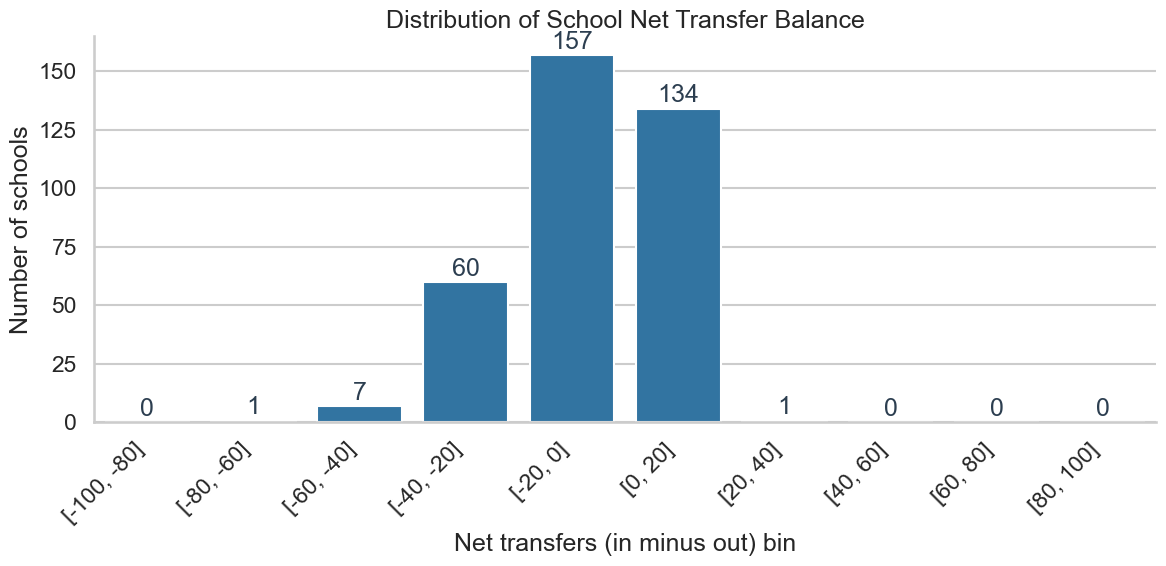

In [9]:
# Visualization – Distribution of school-level net transfer balance
incoming_counts = (
    cfp_clean.loc[cfp_clean["destination"].notna() & (cfp_clean["destination"] != "Uncommitted")]
    .groupby("destination")
    .size()
    .rename("transfers_in")
)
outgoing_counts = cfp_clean.groupby("origin").size().rename("transfers_out")

school_balance = (
    pd.concat([incoming_counts, outgoing_counts], axis=1, sort=True)
    .fillna(0)
    .assign(net=lambda df: df["transfers_in"] - df["transfers_out"])
    .reset_index()
    .rename(columns={"index": "school"})
)

if school_balance.empty:
    print("No school-level records available to compute net transfers.")
else:
    bin_edges = list(range(-100, 101, 20))
    if school_balance["net"].max() > bin_edges[-1]:
        bin_edges.extend(range(bin_edges[-1] + 20, int(school_balance["net"].max()) + 40, 20))
    if school_balance["net"].min() < bin_edges[0]:
        bin_edges = list(range(int(school_balance["net"].min()) - 20, bin_edges[0], 20)) + bin_edges

    school_balance["net_bin"] = pd.cut(
        school_balance["net"],
        bins=bin_edges,
        right=True,
        include_lowest=True,
    )
    bin_counts = (
        school_balance.groupby("net_bin")
        .size()
        .reset_index(name="num_schools")
        .assign(center=lambda df: df["net_bin"].apply(lambda interval: interval.mid))
        .sort_values("center")
    )

    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(
        data=bin_counts,
        x="net_bin",
        y="num_schools",
        color="#1f77b4",
        ax=ax,
    )

    ax.set_title("Distribution of School Net Transfer Balance")
    ax.set_xlabel("Net transfers (in minus out) bin")
    ax.set_ylabel("Number of schools")
    ax.set_xticklabels([f"[{interval.left:.0f}, {interval.right:.0f}]" for interval in bin_counts["net_bin"]], rotation=45, ha="right")

    for patch, count in zip(ax.patches, bin_counts["num_schools"]):
        height = patch.get_height()
        ax.text(
            patch.get_x() + patch.get_width() / 2,
            height + 0.5,
            f"{count}",
            ha="center",
            va="bottom",
            color="#2c3e50",
        )

    ax.spines[["top", "right"]].set_visible(False)
    plt.tight_layout()
    plt.show()


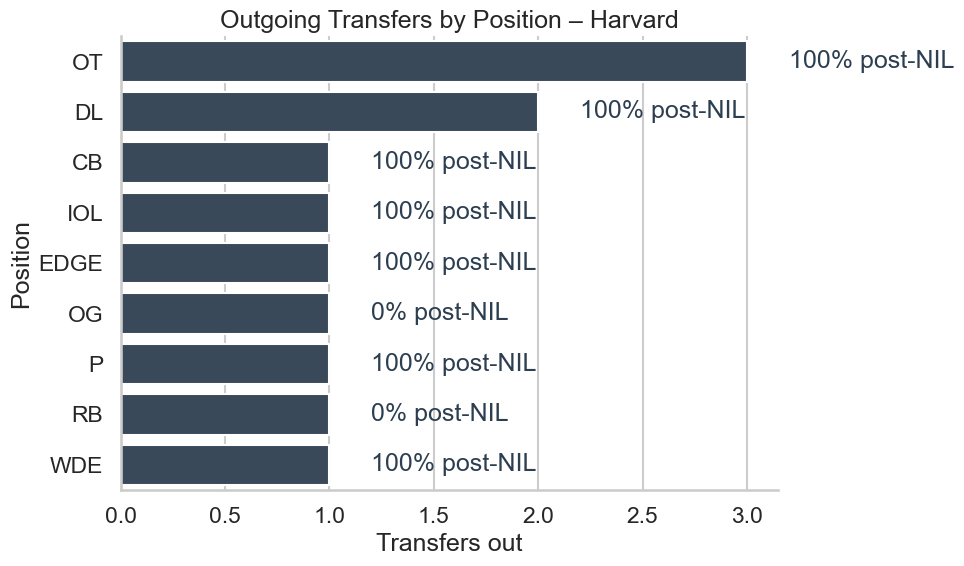

In [10]:

# Visualization 3 – Positions most affected at a selected school
focus_school = "Harvard"  # Change to the school of interest

school_transfers = (
    cfp_clean.loc[cfp_clean["origin"] == focus_school]
    .groupby("position")
    .agg(
        total_transfers=("position", "size"),
        post_nil_transfers=("post_nil", "sum")
    )
    .sort_values("total_transfers", ascending=False)
    .head(10)
    .reset_index()
)

if school_transfers.empty:
    print(f"No outgoing transfers recorded for {focus_school}.")
else:
    school_transfers["post_nil_share"] = school_transfers["post_nil_transfers"] / school_transfers["total_transfers"]

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(data=school_transfers, x="total_transfers", y="position", color="#34495e", ax=ax)
    ax.set_title(f"Outgoing Transfers by Position – {focus_school}")
    ax.set_xlabel("Transfers out")
    ax.set_ylabel("Position")

    for patch, share in zip(ax.patches, school_transfers["post_nil_share"]):
        width = patch.get_width()
        y = patch.get_y() + patch.get_height() / 2
        ax.text(width + 0.2, y, f"{share:.0%} post-NIL", va="center", ha="left", color="#2c3e50")

    ax.spines[["top", "right"]].set_visible(False)
    plt.tight_layout()
    plt.show()


/var/folders/v3/t_6zr38j6kb0bq90clldf46w0000gr/T/ipykernel_61896/1394049715.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  .assign(month=lambda df: df["transfer_date"].dt.to_period("M"))


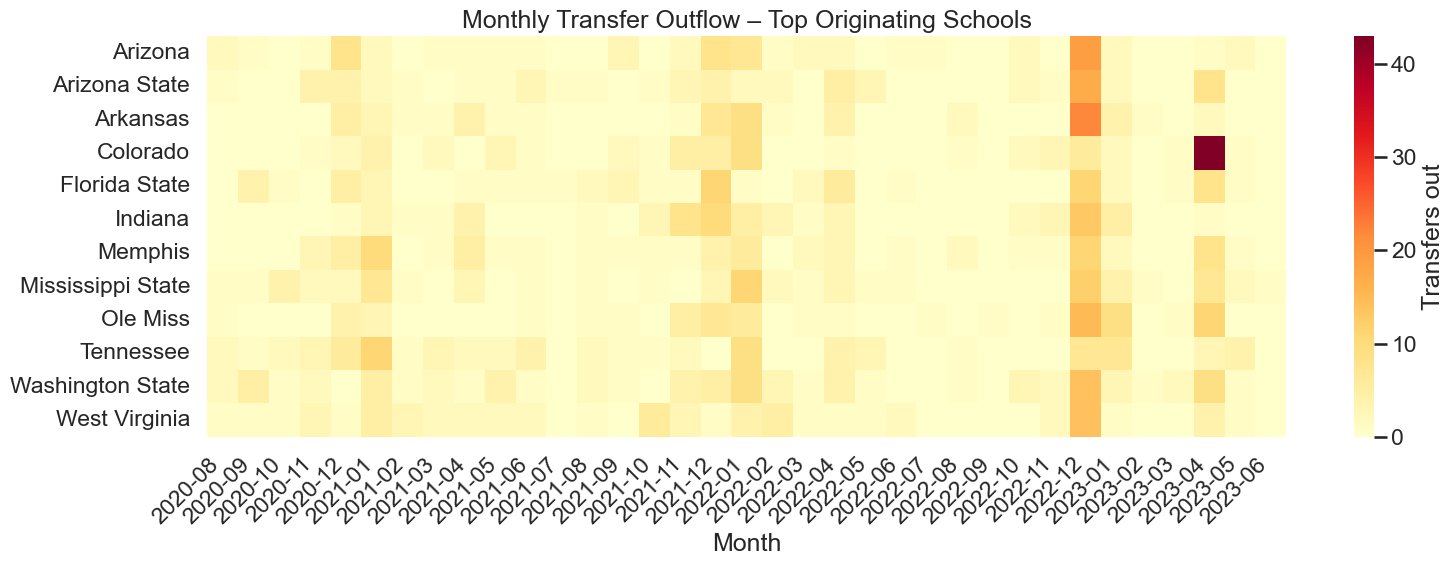

In [11]:

# Visualization 4 – Seasonality of outgoing transfers for high-churn programs
top_origins = (
    cfp_clean.groupby("origin").size().sort_values(ascending=False).head(12).index.tolist()
)

seasonality = (
    cfp_clean.loc[cfp_clean["origin"].isin(top_origins)]
    .dropna(subset=["transfer_date"])
    .assign(month=lambda df: df["transfer_date"].dt.to_period("M"))
    .groupby(["origin", "month"])
    .size()
    .reset_index(name="transfers_out")
)

if seasonality.empty:
    print("No transfer activity available for seasonality heatmap.")
else:
    pivot = seasonality.assign(month=lambda df: df["month"].dt.to_timestamp()).pivot(
        index="origin", columns="month", values="transfers_out"
    ).fillna(0)

    pivot = pivot.reindex(sorted(pivot.columns), axis=1)

    fig, ax = plt.subplots(figsize=(16, 6))
    sns.heatmap(pivot, cmap="YlOrRd", ax=ax, cbar_kws={"label": "Transfers out"})
    ax.set_title("Monthly Transfer Outflow – Top Originating Schools")
    ax.set_xlabel("Month")
    ax.set_ylabel("")
    ax.set_xticklabels([pd.to_datetime(lbl).strftime("%Y-%m") for lbl in pivot.columns], rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


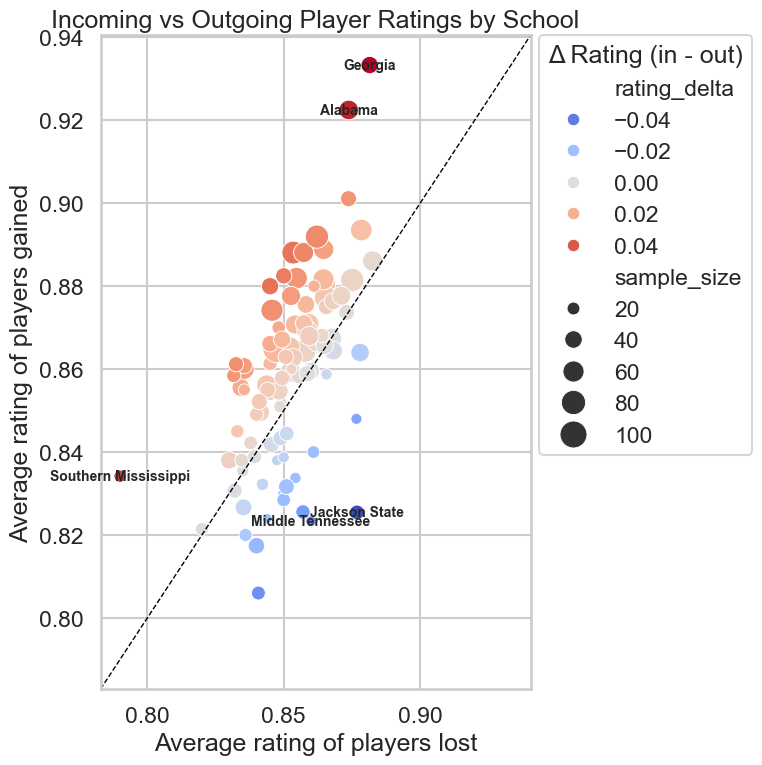

In [12]:

# Visualization 5 – Incoming vs outgoing player rating by school
rated_transfers = cfp_clean.dropna(subset=["rating"])

incoming_rating = (
    rated_transfers.loc[rated_transfers["destination"] != "Uncommitted"]
    .groupby("destination")["rating"]
    .agg(avg_in_rating="mean", incoming_rated="count")
)

outgoing_rating = (
    rated_transfers.groupby("origin")["rating"]
    .agg(avg_out_rating="mean", outgoing_rated="count")
)

rating_delta = (
    incoming_rating.join(outgoing_rating, how="inner")
    .query("incoming_rated >= 5 and outgoing_rated >= 5")
    .assign(
        rating_delta=lambda df: df["avg_in_rating"] - df["avg_out_rating"],
        sample_size=lambda df: df["incoming_rated"] + df["outgoing_rated"]
    )
    .reset_index(names="school")
)

if rating_delta.empty:
    print("Not enough rated transfers to compare incoming vs outgoing talent.")
else:
    min_val = rating_delta[["avg_in_rating", "avg_out_rating"]].min().min()
    max_val = rating_delta[["avg_in_rating", "avg_out_rating"]].max().max()
    padding = (max_val - min_val) * 0.05

    fig, ax = plt.subplots(figsize=(8, 8))
    sns.scatterplot(
        data=rating_delta,
        x="avg_out_rating",
        y="avg_in_rating",
        size="sample_size",
        hue="rating_delta",
        palette="coolwarm",
        ax=ax,
        sizes=(50, 400),
        legend="brief"
    )

    lower = min_val - padding
    upper = max_val + padding
    ax.plot([lower, upper], [lower, upper], color="black", linestyle="--", linewidth=1)
    ax.set_xlim(lower, upper)
    ax.set_ylim(lower, upper)

    ax.set_title("Incoming vs Outgoing Player Ratings by School")
    ax.set_xlabel("Average rating of players lost")
    ax.set_ylabel("Average rating of players gained")
    ax.legend(title="Δ Rating (in - out)", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

    highlight = rating_delta.reindex(
        rating_delta["rating_delta"].abs().sort_values(ascending=False).head(5).index
    )
    for _, row in highlight.iterrows():
        ax.text(row["avg_out_rating"], row["avg_in_rating"], row["school"], fontsize=10, weight="bold", ha="center", va="center")

    plt.tight_layout()
    plt.show()


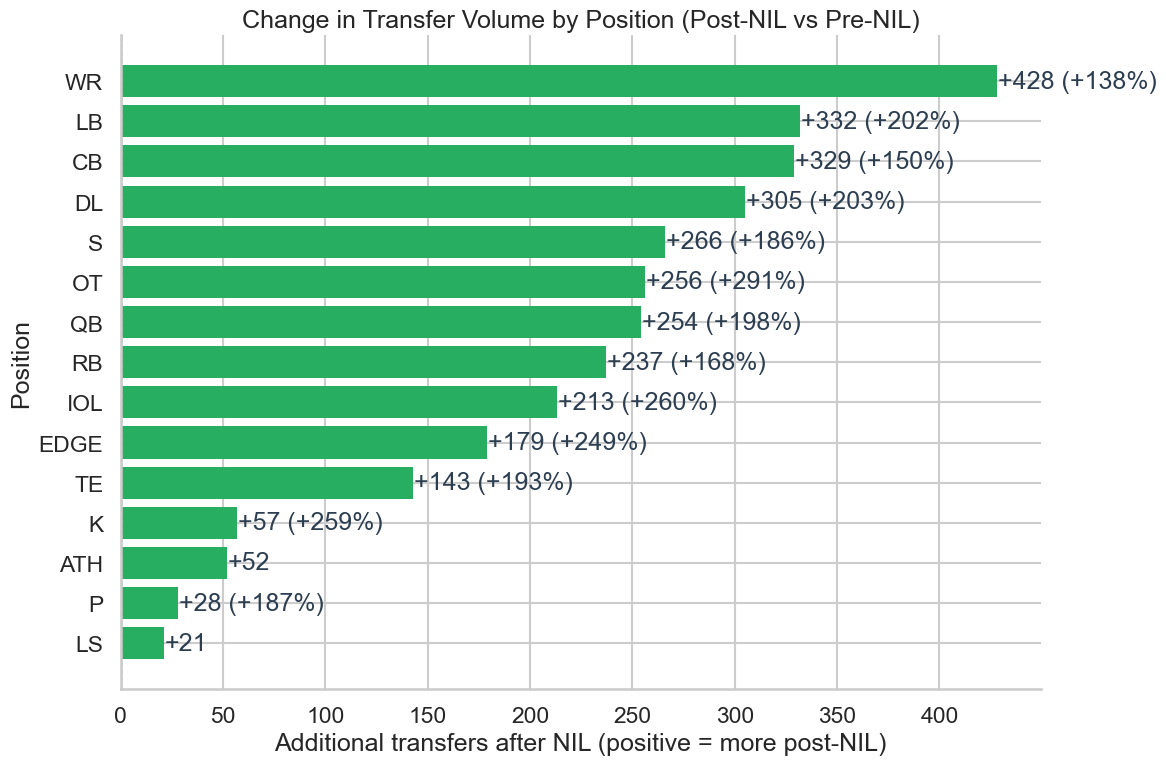

In [13]:
# Visualization – Positions with the biggest post-NIL transfer shift
position_shift = (
    cfp_clean.assign(period=np.where(cfp_clean["post_nil"], "Post-NIL", "Pre-NIL"))
    .groupby(["position", "period"])
    .size()
    .unstack(fill_value=0)
    .rename(columns={"Pre-NIL": "pre_nil", "Post-NIL": "post_nil"})
    .assign(
        total=lambda df: df["pre_nil"] + df["post_nil"],
        delta=lambda df: df["post_nil"] - df["pre_nil"],
        pct_change=lambda df: np.where(
            df["pre_nil"] > 0, df["delta"] / df["pre_nil"], np.nan
        ),
    )
    .loc[lambda df: df["total"] >= 20]  # focus on positions with meaningful volume
)

if position_shift.empty:
    print("Not enough position-level transfer data to compare pre- vs post-NIL periods.")
else:
    top_positions = (
        position_shift.assign(abs_delta=lambda df: df["delta"].abs())
        .sort_values("abs_delta", ascending=False)
        .head(15)
        .reset_index()
    )

    ordered = top_positions.sort_values("delta")
    colors = ordered["delta"].apply(lambda x: "#27ae60" if x >= 0 else "#e74c3c")

    fig, ax = plt.subplots(figsize=(12, 8))
    bars = ax.barh(
        y=ordered["position"],
        width=ordered["delta"],
        color=colors,
        edgecolor="none",
    )

    ax.axvline(0, color="black", linewidth=1, linestyle="--")
    ax.set_title("Change in Transfer Volume by Position (Post-NIL vs Pre-NIL)")
    ax.set_xlabel("Additional transfers after NIL (positive = more post-NIL)")
    ax.set_ylabel("Position")

    for bar, (_, row) in zip(bars, ordered.iterrows()):
        width = bar.get_width()
        y = bar.get_y() + bar.get_height() / 2
        label = f"{row['delta']:+.0f}"
        pct = (
            f" ({row['pct_change']:+.0%})"
            if pd.notnull(row["pct_change"]) and abs(row["pct_change"]) < 5
            else ""
        )
        ax.text(
            width + (0.5 if width >= 0 else -0.5),
            y,
            label + pct,
            va="center",
            ha="left" if width >= 0 else "right",
            color="#2c3e50",
        )

    ax.spines[["top", "right"]].set_visible(False)
    plt.tight_layout()
    plt.show()


/var/folders/v3/t_6zr38j6kb0bq90clldf46w0000gr/T/ipykernel_61896/3125954988.py:80: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  fbs = pd.read_html(fbs_html)[0]
/var/folders/v3/t_6zr38j6kb0bq90clldf46w0000gr/T/ipykernel_61896/3125954988.py:81: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  fcs = pd.read_html(fcs_html)[0]


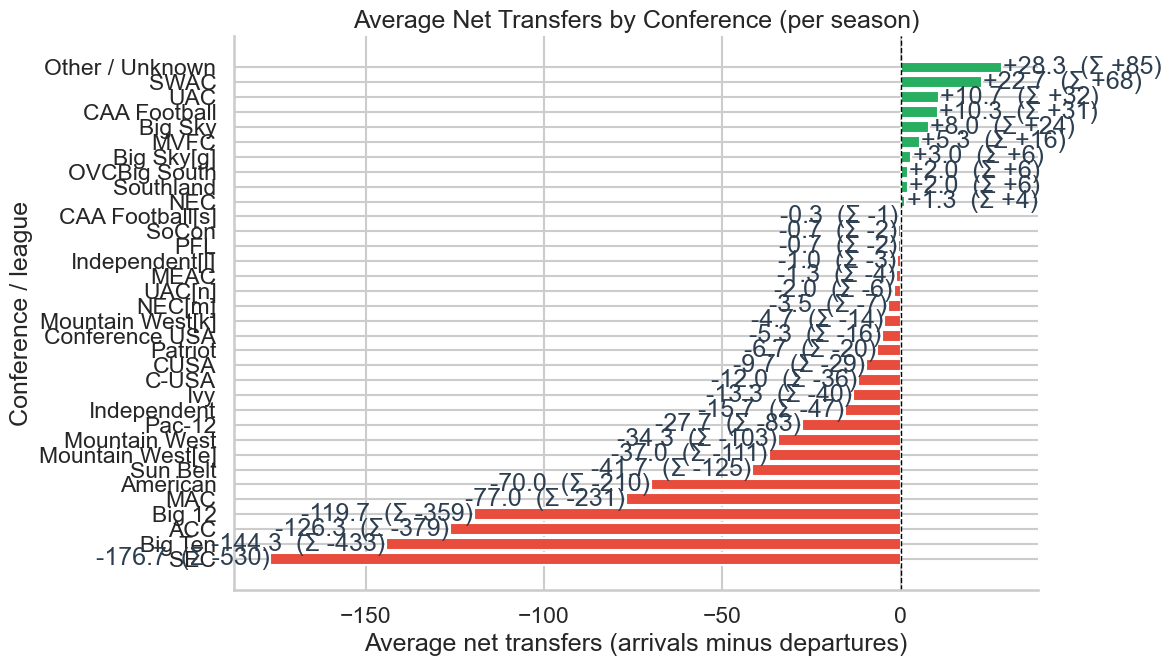

In [14]:

# Visualization – Average net transfers (in minus out) by conference/league
import requests
import re
from unicodedata import normalize


def _normalize_text(value):
    if pd.isna(value):
        return value
    text = normalize('NFKD', str(value)).encode('ASCII', 'ignore').decode('ASCII')
    return re.sub(r'\s+', ' ', text).strip()


def _canonical_school(name):
    if not isinstance(name, str):
        return None
    text = normalize('NFKD', name).encode('ASCII', 'ignore').decode('ASCII').lower()
    text = re.sub(r'\(.*?\)', '', text)
    replacements = [
        ('state university of new york at', ''),
        ('state university of new york', ''),
        ('university of', ''),
        ('the ', ''),
        ('college', ''),
        ('university', ''),
        ('institute', ''),
        ('campus', ''),
        ('&', ' and '),
    ]
    for old, new in replacements:
        text = text.replace(old, new)
    text = text.replace('st.', 'saint').replace("'", '').replace('-', ' ').replace('.', ' ').replace('/', ' ')
    text = re.sub(r'(of|at)', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    aliases = {
        'texas a m': 'texasam',
        'texas am': 'texasam',
        'texas christian': 'tcu',
        'southern california': 'usc',
        'california los angeles': 'ucla',
        'central florida': 'ucf',
        'south florida': 'usf',
        'texas san antonio': 'utsa',
        'texas el paso': 'utep',
        'texas rio grande valley': 'utrgv',
        'louisiana monroe': 'ulm',
        'louisiana lafayette': 'louisiana',
        'miami fl': 'miami',
        'miami oh': 'miamioh',
        'florida international': 'fiu',
        'florida atlantic': 'fau',
        'brigham young': 'byu',
        'massachusetts': 'umass',
        'pennsylvania': 'penn',
    }
    for key, value in aliases.items():
        if key in text:
            text = value
            break

    text = text.replace('saint', 'st')
    return text.replace(' ', '')


def _build_conference_map():
    headers = {'User-Agent': 'Mozilla/5.0'}
    try:
        fbs_html = requests.get(
            'https://en.wikipedia.org/wiki/List_of_NCAA_Division_I_FBS_football_programs',
            headers=headers,
            timeout=30,
        ).text
        fcs_html = requests.get(
            'https://en.wikipedia.org/wiki/List_of_NCAA_Division_I_FCS_football_programs',
            headers=headers,
            timeout=30,
        ).text

        fbs = pd.read_html(fbs_html)[0]
        fcs = pd.read_html(fcs_html)[0]
    except Exception as exc:  # pragma: no cover - defensive
        print(f"⚠️ Could not fetch conference mappings ({exc}). Using fallback labels.")
        return {}

    fbs.columns = [col.split('[')[0].strip() for col in fbs.columns]
    fcs.columns = [col.split('[')[0].strip() for col in fcs.columns]

    fbs = fbs[['School', 'Current conference']].rename(columns={'Current conference': 'Conference'})
    fcs = fcs[['School', 'Conference']]

    combined = pd.concat([fbs, fcs], ignore_index=True)
    combined['School'] = combined['School'].apply(_normalize_text)
    combined['Conference'] = combined['Conference'].apply(_normalize_text)
    combined['key'] = combined['School'].apply(_canonical_school)

    mapping = dict(zip(combined['key'], combined['Conference']))
    mapping.update(
        {
            'miami': 'ACC',
            'miamioh': 'MAC',
            'connecticut': 'Independent',
            'fiu': 'C-USA',
            'fau': 'American',
            'utsa': 'American',
            'utep': 'C-USA',
            'byu': 'Big 12',
            'army': 'American',
            'navy': 'American',
            'notredame': 'Independent',
            'umass': 'Independent',
            'newmexicostate': 'Conference USA',
            'samhouston': 'Conference USA',
            'jacksonville': 'FCS Independent',
        }
    )
    return mapping


conference_map = _build_conference_map()


def _lookup_conference(name):
    key = _canonical_school(name)
    return conference_map.get(key, 'Other / Unknown')


cfp_clean['origin_conference'] = cfp_clean['origin'].fillna('Unknown').apply(_lookup_conference)
cfp_clean['destination_conference'] = (
    cfp_clean['destination'].fillna('Unknown').apply(_lookup_conference)
)

incoming = (
    cfp_clean.loc[cfp_clean['destination'] != 'Uncommitted']
    .groupby(['destination_conference', 'season'])
    .size()
    .rename('transfers_in')
    .reset_index()
)

outgoing = (
    cfp_clean.groupby(['origin_conference', 'season'])
    .size()
    .rename('transfers_out')
    .reset_index()
)

net_transfers = outgoing.merge(
    incoming,
    how='outer',
    left_on=['origin_conference', 'season'],
    right_on=['destination_conference', 'season'],
)

net_transfers['transfers_in'] = net_transfers['transfers_in'].fillna(0)
net_transfers['transfers_out'] = net_transfers['transfers_out'].fillna(0)
net_transfers['origin_conference'] = net_transfers['origin_conference'].fillna(net_transfers['destination_conference'])
net_transfers['destination_conference'] = net_transfers['destination_conference'].fillna(net_transfers['origin_conference'])
net_transfers['conference'] = net_transfers['origin_conference']
net_transfers['net'] = net_transfers['transfers_in'] - net_transfers['transfers_out']

conference_summary = (
    net_transfers.groupby('conference')
    .agg(
        avg_net=('net', 'mean'),
        total_net=('net', 'sum'),
        seasons=('net', 'size'),
    )
    .reset_index()
    .sort_values('avg_net')
)

fig, ax = plt.subplots(figsize=(12, 7))
colors = conference_summary['avg_net'].apply(lambda v: '#27ae60' if v >= 0 else '#e74c3c')
ax.barh(conference_summary['conference'], conference_summary['avg_net'], color=colors)
ax.axvline(0, color='black', linestyle='--', linewidth=1)
ax.set_title('Average Net Transfers by Conference (per season)')
ax.set_xlabel('Average net transfers (arrivals minus departures)')
ax.set_ylabel('Conference / league')

for patch, (_, row) in zip(ax.patches, conference_summary.iterrows()):
    width = patch.get_width()
    y = patch.get_y() + patch.get_height() / 2
    label = f"{row['avg_net']:+.1f}  (Σ {row['total_net']:+.0f})"
    ax.text(
        width + (0.3 if width >= 0 else -0.3),
        y,
        label,
        va='center',
        ha='left' if width >= 0 else 'right',
        color='#2c3e50',
    )

ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()


/var/folders/v3/t_6zr38j6kb0bq90clldf46w0000gr/T/ipykernel_61896/4131822796.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/v3/t_6zr38j6kb0bq90clldf46w0000gr/T/ipykernel_61896/4131822796.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


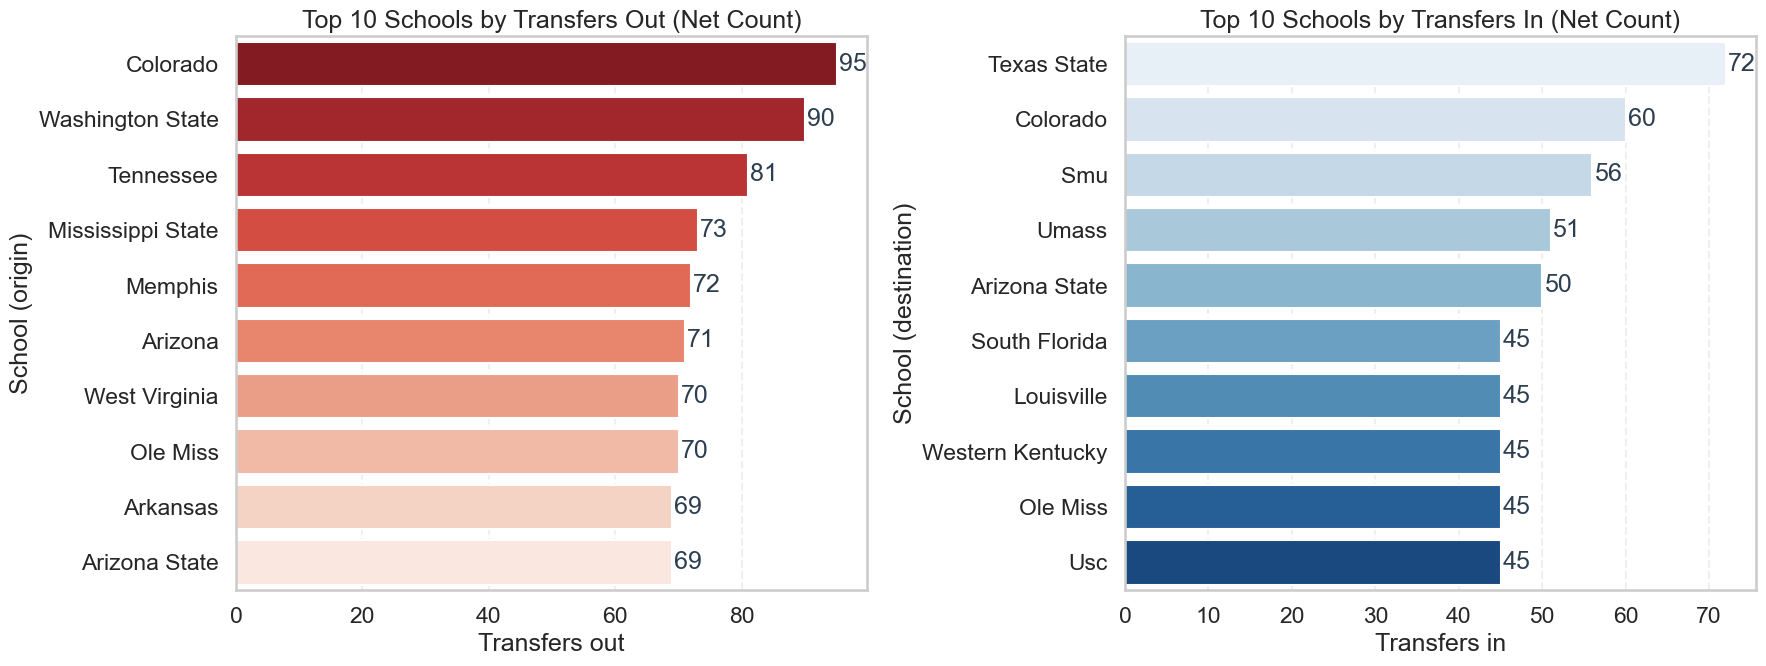

In [ ]:

# Visualization – Top transfer pipelines (schools losing vs gaining talent)
outgoing_top10 = (
    cfp_clean.groupby('origin')
    .size()
    .sort_values(ascending=False)
    .head(10)
    .reset_index(name='transfers_out')
)

incoming_top10 = (
    cfp_clean.loc[cfp_clean['destination'] != 'Uncommitted']
    .groupby('destination')
    .size()
    .sort_values(ascending=False)
    .head(10)
    .reset_index(name='transfers_in')
)

fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=False)

sns.barplot(
    data=outgoing_top10,
    x='transfers_out',
    y='origin',
    ax=axes[0],
    palette='Reds_r'
)
axes[0].set_title('Top 10 Schools by Transfers Out (Net Count)')
axes[0].set_xlabel('Transfers out')
axes[0].set_ylabel('School (origin)')
axes[0].grid(True, axis='x', linestyle='--', alpha=0.3)

for bar, value in zip(axes[0].patches, outgoing_top10['transfers_out']):
    axes[0].text(bar.get_width() + 0.3, bar.get_y() + bar.get_height() / 2,
                 f'{value}', va='center', ha='left', color='#2c3e50')

sns.barplot(
    data=incoming_top10,
    x='transfers_in',
    y='destination',
    ax=axes[1],
    palette='Blues'
)
axes[1].set_title('Top 10 Schools by Transfers In (Net Count)')
axes[1].set_xlabel('Transfers in')
axes[1].set_ylabel('School (destination)')
axes[1].grid(True, axis='x', linestyle='--', alpha=0.3)

for bar, value in zip(axes[1].patches, incoming_top10['transfers_in']):
    axes[1].text(bar.get_width() + 0.3, bar.get_y() + bar.get_height() / 2,
                 f'{value}', va='center', ha='left', color='#2c3e50')

plt.tight_layout()
plt.show()


In [ ]:
c